In [1]:
import itertools
import random
from dataclasses import dataclass
from typing import List, Optional

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import Parameter
from torchtyping import TensorType, patch_typeguard
from tqdm.notebook import tqdm

from exos import EXOS
from hand import (Transformer, model_diff, perturb, set_debug, show_matrix, pprint_2d_tensor,
                  show_activations, show_transformer, show_batch, get_activations)

%load_ext autoreload
%autoreload 2
%matplotlib inline


# Training + Setup

In [2]:
PB = "IfThenElse"
EXO = EXOS[PB]
tokenizer = EXO.tokenizer
def gen_goal(n: int):
    xs, ys = EXO.generate(n)
    xs = EXO.tokenizer.encode(xs)
    ys = EXO.tokenizer.encode(ys, pad=False)
    return xs, ys
# def gen_goal(n: int):
#     xs ["00", "01", "10", "11"]
#     ys = ["0", "1", "1", "0"]
#     xs = EXO.tokenizer.encode(xs)
#     ys = EXO.tokenizer.encode(ys, pad=False)
#     return xs, ys
def gen_goal(_: int):
    xs = [''.join(s) for s in itertools.product("01", repeat=3)]
    ys = [s[1:][s[0] == "0"] for s in xs]
    xs = EXO.tokenizer.encode(xs)
    ys = EXO.tokenizer.encode(ys, pad=False)
    return xs, ys
EXO

IfThenElse
Input: XYZ. Complete by Y if X == 1 otherwise by Z.

Alphabet: 0: ''  1: 0  2: 1
Input length: 3
Examples:
  000 → 0
  100 → 0
  011 → 1
  011 → 1
  001 → 1

0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 loss: 1.0515204668045044
Epoch 200 loss: 1.0298928022384644
Epoch 400 loss: 0.6043149828910828
Epoch 600 loss: 0.5868749022483826
Epoch 800 loss: 0.5889276266098022
Epoch 1000 loss: 0.5833994150161743
Epoch 1200 loss: 0.5811222195625305
Epoch 1400 loss: 0.5821641683578491
Epoch 1600 loss: 0.5829666256904602
Epoch 1800 loss: 0.5834273099899292
Epoch 2000 loss: 0.5836873650550842
010 → 0         	'': 0.00  0: 0.95  1: 0.04
111 → 1         	'': 0.01  0: 0.01  1: 0.98
101 → 0         	'': 0.00  0: 0.92  1: 0.08
100 → 0         	'': 0.00  0: 0.97  1: 0.02
001 → 1         	'': 0.02  0: 0.06  1: 0.92
100 → 0         	'': 0.00  0: 0.97  1: 0.02
100 → 0         	'': 0.00  0: 0.97  1: 0.02
001 → 1         	'': 0.02  0: 0.06  1: 0.92
111 → 1         	'': 0.01  0: 0.01  1: 0.98
110 → 1         	'': 0.03  0: 0.10  1: 0.87
Loss: 0.58  Accuracy: 1000 / 1000


(1000, 0.5831476449966431)

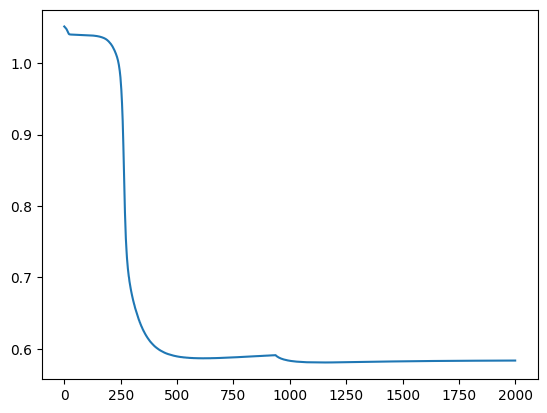

In [5]:


depth = 1
heads = 1
embedding_size = 12
mlp = 8,

# pos_encoder=torch.eye(tokenizer.max_len, embedding_size)
pos_encoder = torch.cat([
    torch.zeros(tokenizer.max_len, 3),
    torch.eye(tokenizer.max_len, embedding_size - 3),
    ], dim=1)
pprint_2d_tensor(pos_encoder)
transformer = Transformer(
    voc_size=tokenizer.vocab_size, 
    embedding_size=embedding_size,
    depth=depth,
    heads=heads,
    pos_encoder=pos_encoder,
    mlp_dims=()
)

if "Force (un)embedding":
    transformer.embedding.weight = Parameter(
        torch.eye(*transformer.embedding.weight.shape), requires_grad=False)
    # transformer.embedding.weight = Parameter(
    #     5 * torch.cat([
    #         torch.tensor([[0], [1], [-1]]),
    #         torch.zeros(tokenizer.vocab_size, embedding_size - 1),
    #     ], dim=1), requires_grad=False)
    transformer.unembedding = Parameter(transformer.embedding.weight.T, requires_grad=False)

data = train(transformer, 
    epochs=2000,
    batch_size=8,
    lr=0.1,
    weight_decay=0.01,
    data=TrainingData(None, [], transformer)
)

data.plot_loss()
EXO.test(transformer, 1000)

In [2]:
t = torch.load("./ITE-1-layer")
# data = TrainingData(None, [], t)

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1 loss: 0.5593876242637634
Epoch 2000 loss: 0.556840717792511
Epoch 4000 loss: 0.5557031035423279
Epoch 6000 loss: 0.5550931096076965
Epoch 8000 loss: 0.5547296404838562
Epoch 10000 loss: 0.5544983148574829
Epoch 12000 loss: 0.554344117641449
Epoch 14000 loss: 0.5542382597923279
Epoch 16000 loss: 0.5541638731956482
Epoch 18000 loss: 0.5541107058525085
Epoch 20000 loss: 0.5540720820426941


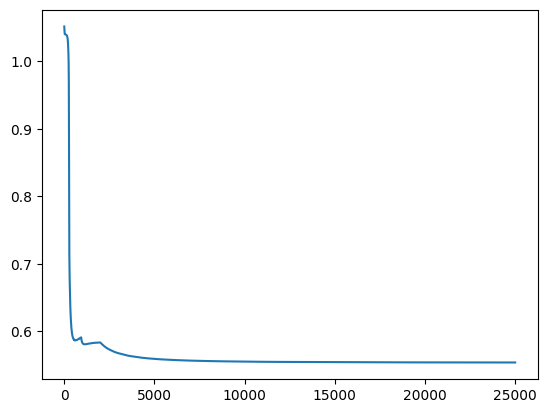

In [8]:
data = train(transformer, 20000, data=data)
data.plot_loss()

In [51]:
torch.save(t, "./ITE-25k-epochs")

In [ ]:
saved = transformer

# Inspection of the model

In [9]:
original = torch.load("./ITE-25k-epochs")
experiment = torch.load("./ITE-25k-epochs")

with torch.no_grad():
    # zero out the mlp
    mlp: torch.nn.Linear = experiment.blocks[1].layers[0]
    mlp.weight = Parameter(torch.zeros_like(mlp.weight))
    mlp.bias = Parameter(torch.zeros_like(mlp.bias))

    # zero the 0.W on dims > 2
    experiment.blocks[0].weight[:, 3:] = 0
    experiment.blocks[0].weight[:, 0] = 0

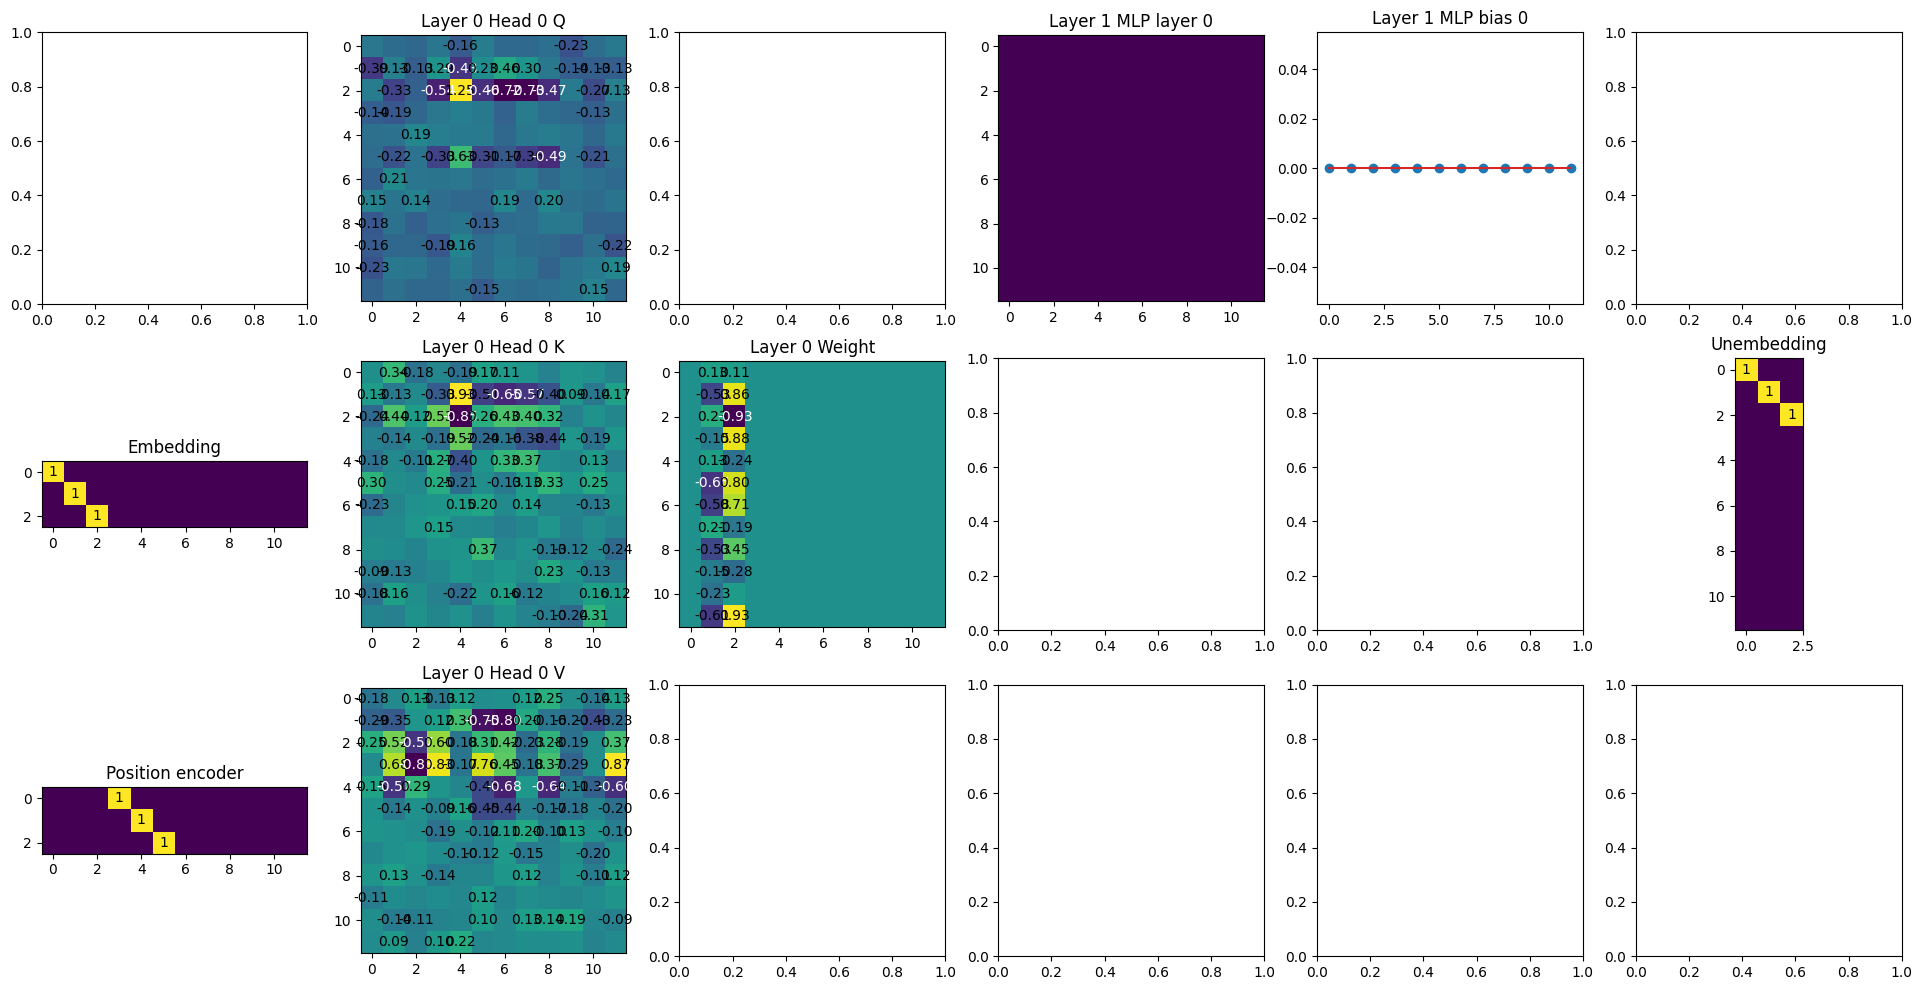

In [10]:
transformer = experiment
show_transformer(transformer)

## OV Circuit analysis

In [78]:
def label_if_then_else(only_x=False):
    plt.xticks([0, 1, 2, 3, 4, 5], ["pad", "0", "1", "p0", "p1", "p2"])
    if not only_x:
        plt.yticks([0, 1, 2, 3, 4, 5], ["pad", "0", "1", "p0", "p1", "p2"])

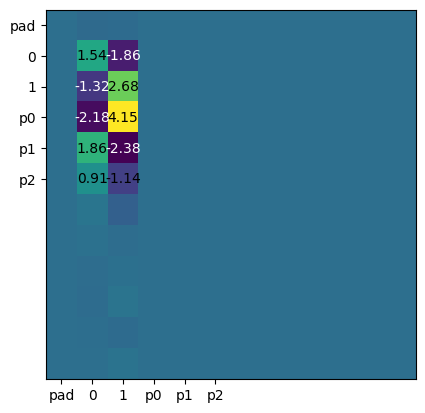

In [73]:
# OV circuit
v = transformer.blocks[0].heads[0].values
w = transformer.blocks[0].weight
show_matrix(v @ w)
label_if_then_else()

In [71]:
OV = (v @ w).detach()
def mk_token(pos, t):
    r = torch.zeros_like(OV[:, 0])
    r[t + 1] = 1
    r[3 + pos] = 1
    return r
def to_string(t):
    return "".join(
        "10"[int(t[1])] if t[p + 3] else "_"
        for p in range(3)
    )

tokens = [mk_token(pos, t) for pos in range(3) for t in range(2)]

print("Write/erase strength in dim '0' given the token attended to")
strengths0 = [(t @ OV)[1].item() for t in tokens]
strengths1 = [(t @ OV)[2].item() for t in tokens]
strengths0, indices = torch.tensor(strengths0).sort(descending=True)
print("Token   0     1")
for s, t in zip(strengths0, indices):
    print(f"{to_string(tokens[t])}  {s:+.2f}  {strengths1[t]:+.2f}")


Write/erase strength in dim '0' given the token attended to
Token   0     1
_0_  +3.40  -4.24
__0  +2.45  -2.99
_1_  +0.54  +0.30
__1  -0.41  +1.54
0__  -0.64  +2.30
1__  -3.50  +6.83


## QK Circuit analysis

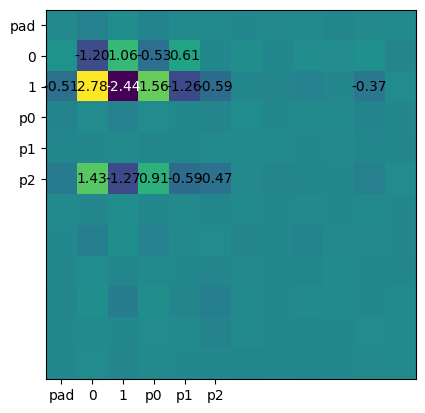

In [74]:
q = transformer.blocks[0].heads[0].queries
k = transformer.blocks[0].heads[0].keys
show_matrix(q @ k.T)
label_if_then_else()

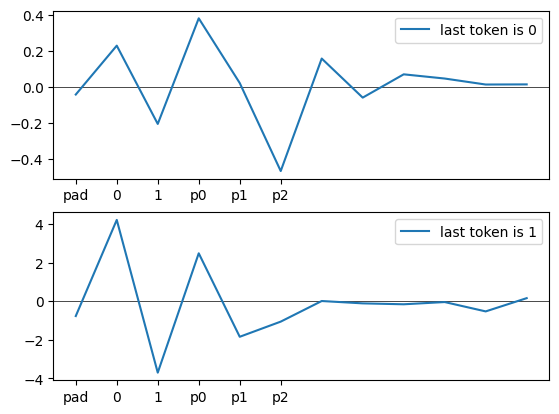

In [91]:
QK = (q @ k.T).detach()
# Two plots
plt.subplot(2, 1, 1)
x0 = QK[5] + QK[1]
plt.axhline(0, color="black", linewidth=0.5)
plt.plot(x0, label="last token is 0")
plt.legend()
label_if_then_else(only_x=True)
# Same but normalized
plt.subplot(2, 1, 2)
x1 = QK[5] + QK[2]
plt.axhline(0, color="black", linewidth=0.5)
plt.plot(x1, label="last token is 1")
plt.legend();
label_if_then_else(only_x=True)


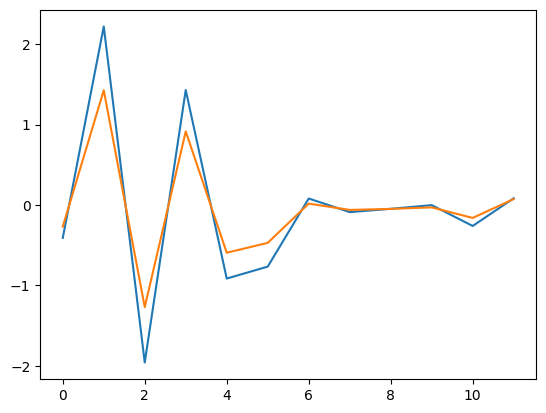

In [92]:
plt.plot((x0 + x1) / 2)
plt.plot(QK[5])
# The average of the two is roughly given by just position 2 dimension of QK 

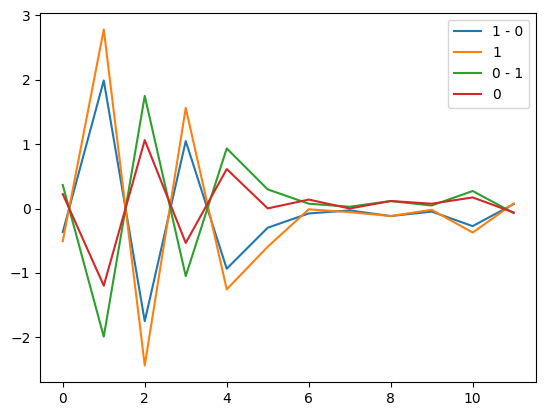

In [98]:
plt.plot(-(x0 - x1) / 2, label="1 - 0")
plt.plot(QK[2], label="1")

plt.plot((x0 - x1) / 2 , label="0 - 1")
plt.plot(QK[1], label="0")
plt.legend()

In [42]:
print(x0[2] + x0[3])
print(x0[1] + x0[4])

tensor(0.1734)
tensor(0.2487)


In [33]:
print(x1[1] + x1[4])
print(x1[2] + x0[3])

tensor(2.3594)
tensor(-3.3270)


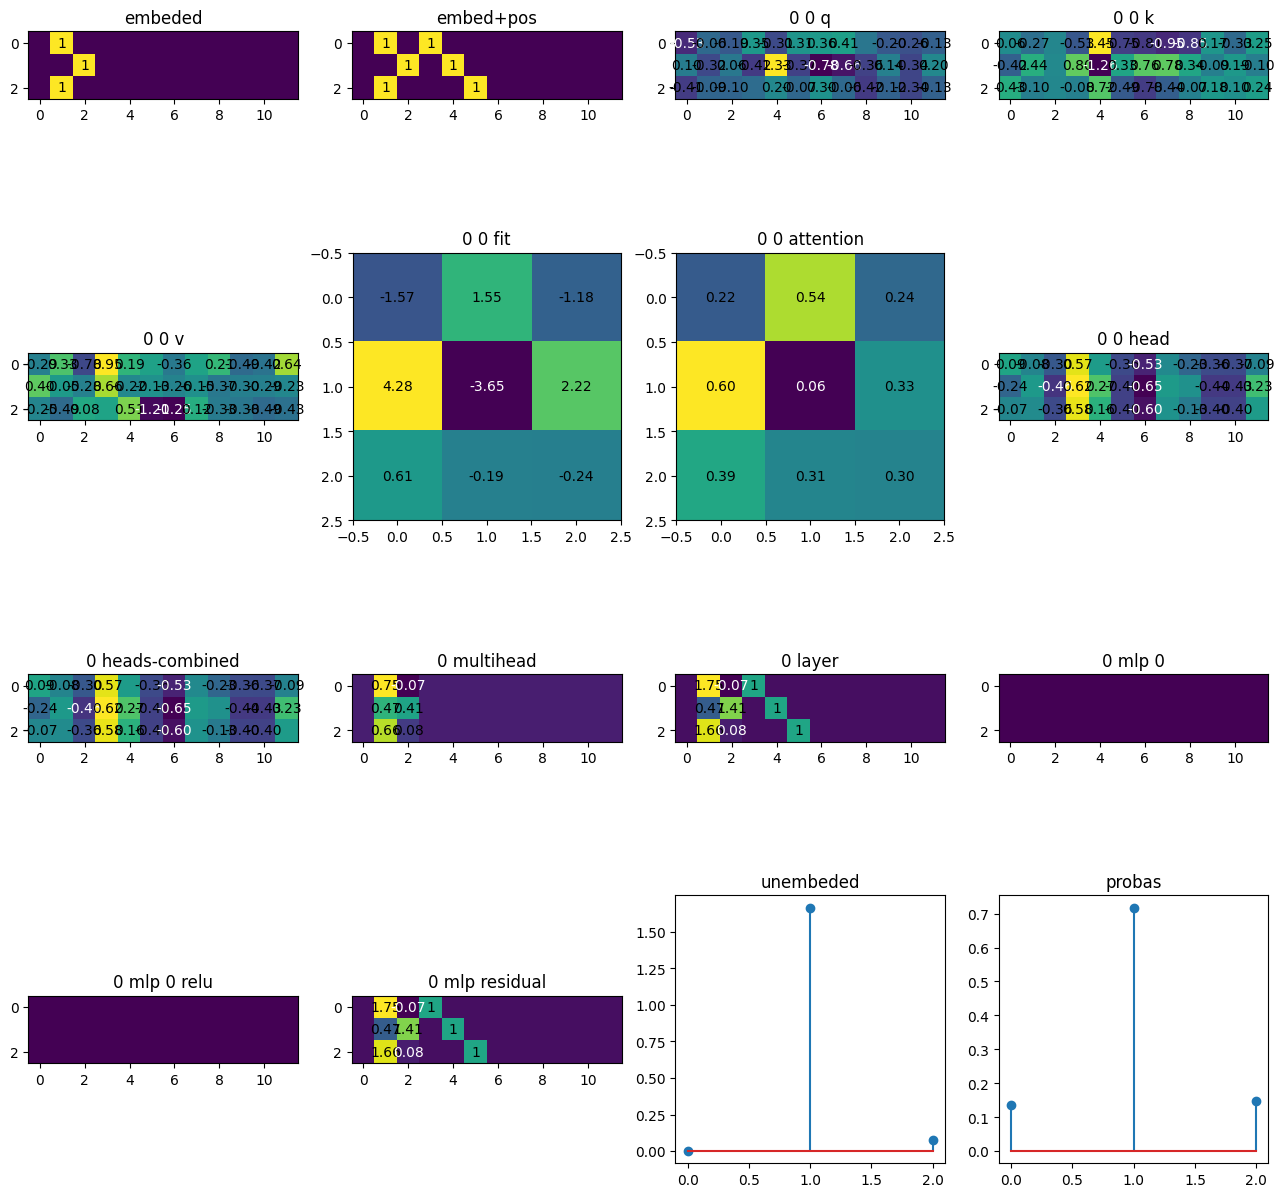

In [100]:
show_activations(transformer, torch.tensor([[1, 2, 1]]))

In [11]:
torch.save(transformer, "./ITE-25k-epochs-MLP_is_one_dim")

In [109]:
all_prompts = EXO.tokenizer.encode([''.join(s) for s in itertools.product("01", repeat=3)])
activations = get_activations(transformer, all_prompts)
for name in activations:
    print(name)

embeded
embed+pos
0 0 q
0 0 k
0 0 v
0 0 fit
0 0 attention
0 0 head
0 heads-combined
0 multihead
0 layer
0 mlp 0
0 mlp 0 relu
0 mlp residual
unembeded
probas


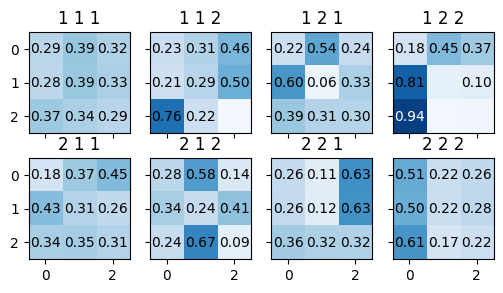

In [151]:
show_batch(activations["0 0 attention"], all_prompts, width=4, vmin=0, vmax=1, cmap="Blues")

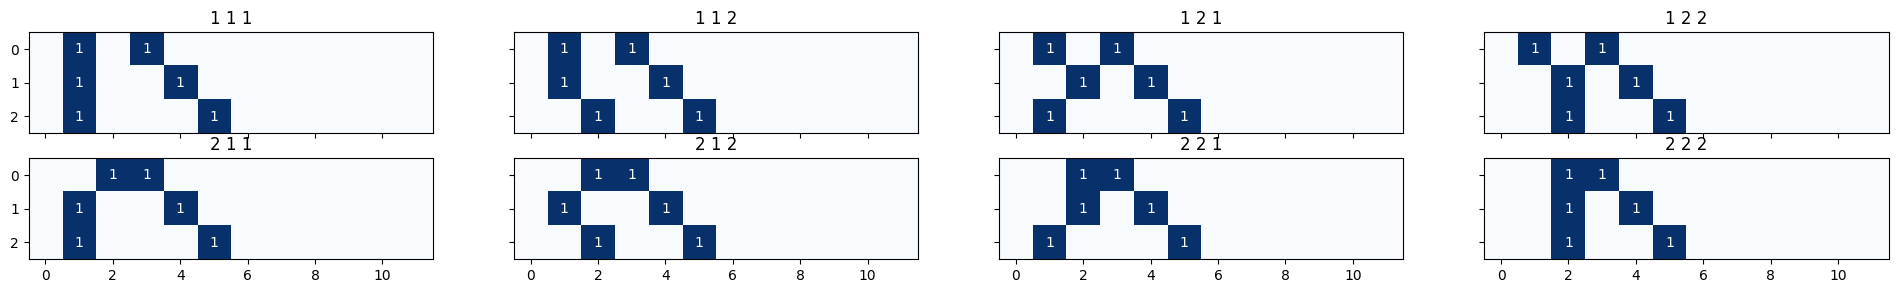

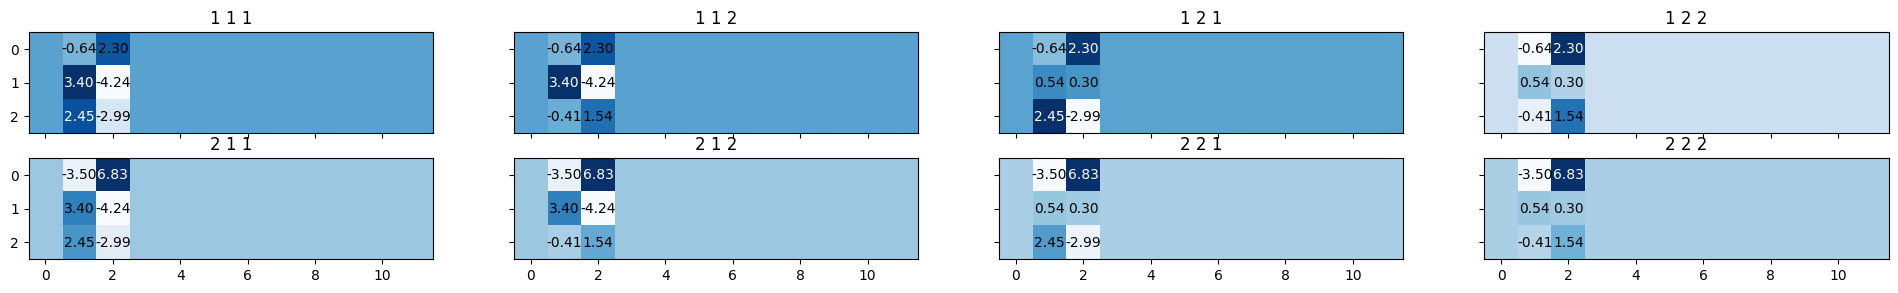

In [127]:
show_batch(activations["embed+pos"], all_prompts, width=4, cmap="Blues")
show_batch(activations["0 0 v"] @ transformer.blocks[0].weight, all_prompts, width=4, cmap="Blues")

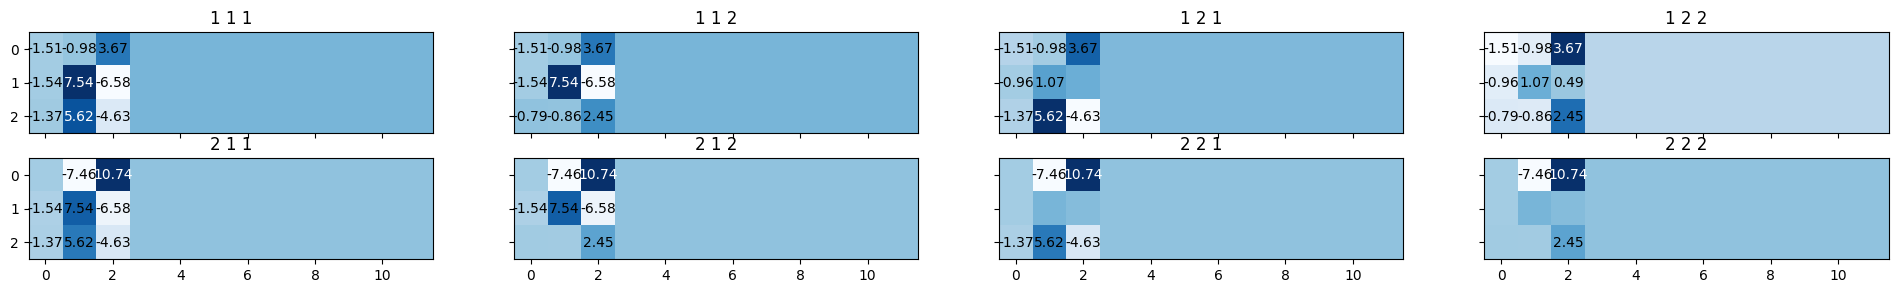

In [150]:
show_batch(activations["0 0 v"] @ transformer.blocks[0].weight, all_prompts, width=4, cmap="Blues")

In [82]:
import copy
saved = copy.deepcopy(transformer)
torch.save(transformer, "./ITE-1-layer")

In [130]:
loss_ablated = EXO.test(experiment)[1]
loss_original = EXO.test(original, verbose=False)[1]
print(f"Loss ablated: {loss_ablated}")
print(f"Loss original: {loss_original}")
print(f"Loss difference: {loss_original - loss_ablated}")

111 → 1         	'': 0.00  0: 0.00  1: 1.00
100 → 0         	'': 0.13  0: 0.75  1: 0.12
110 → 1         	'': 0.13  0: 0.25  1: 0.62
001 → 1         	'': 0.11  0: 0.15  1: 0.74
011 → 1         	'': 0.04  0: 0.02  1: 0.94
101 → 0         	'': 0.16  0: 0.68  1: 0.15
000 → 0         	'': 0.07  0: 0.92  1: 0.02
010 → 0         	'': 0.14  0: 0.72  1: 0.15
Loss: 0.70  Accuracy: 8 / 8
Loss ablated: 0.6982007026672363
Loss original: 0.553645133972168
Loss difference: -0.14455556869506836


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1 loss: 0.5581326484680176
Epoch 1000 loss: 0.5580347180366516
Epoch 2000 loss: 0.5579471588134766
Epoch 3000 loss: 0.5578685998916626
Epoch 4000 loss: 0.5577979683876038
Epoch 5000 loss: 0.5577344298362732
Epoch 6000 loss: 0.5576770305633545
Epoch 7000 loss: 0.5576253533363342
Epoch 8000 loss: 0.5575783848762512
Epoch 9000 loss: 0.5575360059738159
Epoch 10000 loss: 0.5574973821640015


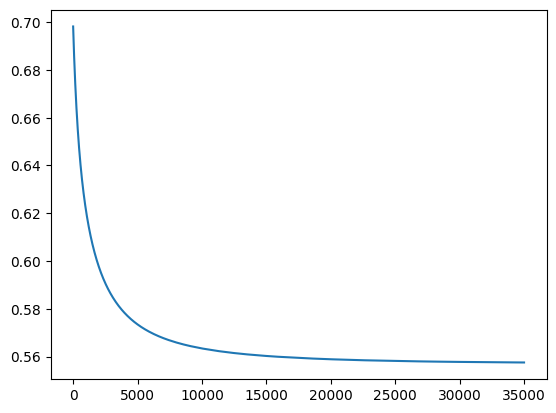

In [149]:
train(experiment, epochs=10000, data=data)
data.plot_loss()

# Comparision with hand made

IfThenElse
Input: XYZ. Complete by Y if X == 1 otherwise by Z.

Alphabet: 0: ''  1: 0  2: 1
Input length: 3
Examples:
  101 → 0
  101 → 0
  101 → 0
  011 → 1
  101 → 0
000 → 0         	'': 0.00  0: 1.00  1: 0.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
101 → 0         	'': 0.00  0: 1.00  1: 0.00
110 → 1         	'': 0.00  0: 0.00  1: 1.00
010 → 0         	'': 0.00  0: 1.00  1: 0.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
100 → 0         	'': 0.03  0: 0.93  1: 0.03
111 → 1         	'': 0.00  0: 0.00  1: 1.00
001 → 1         	'': 0.00  0: 0.00  1: 1.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
Loss: 0.56  Accuracy: 1000 / 1000


(1000, 0.5623834133148193)

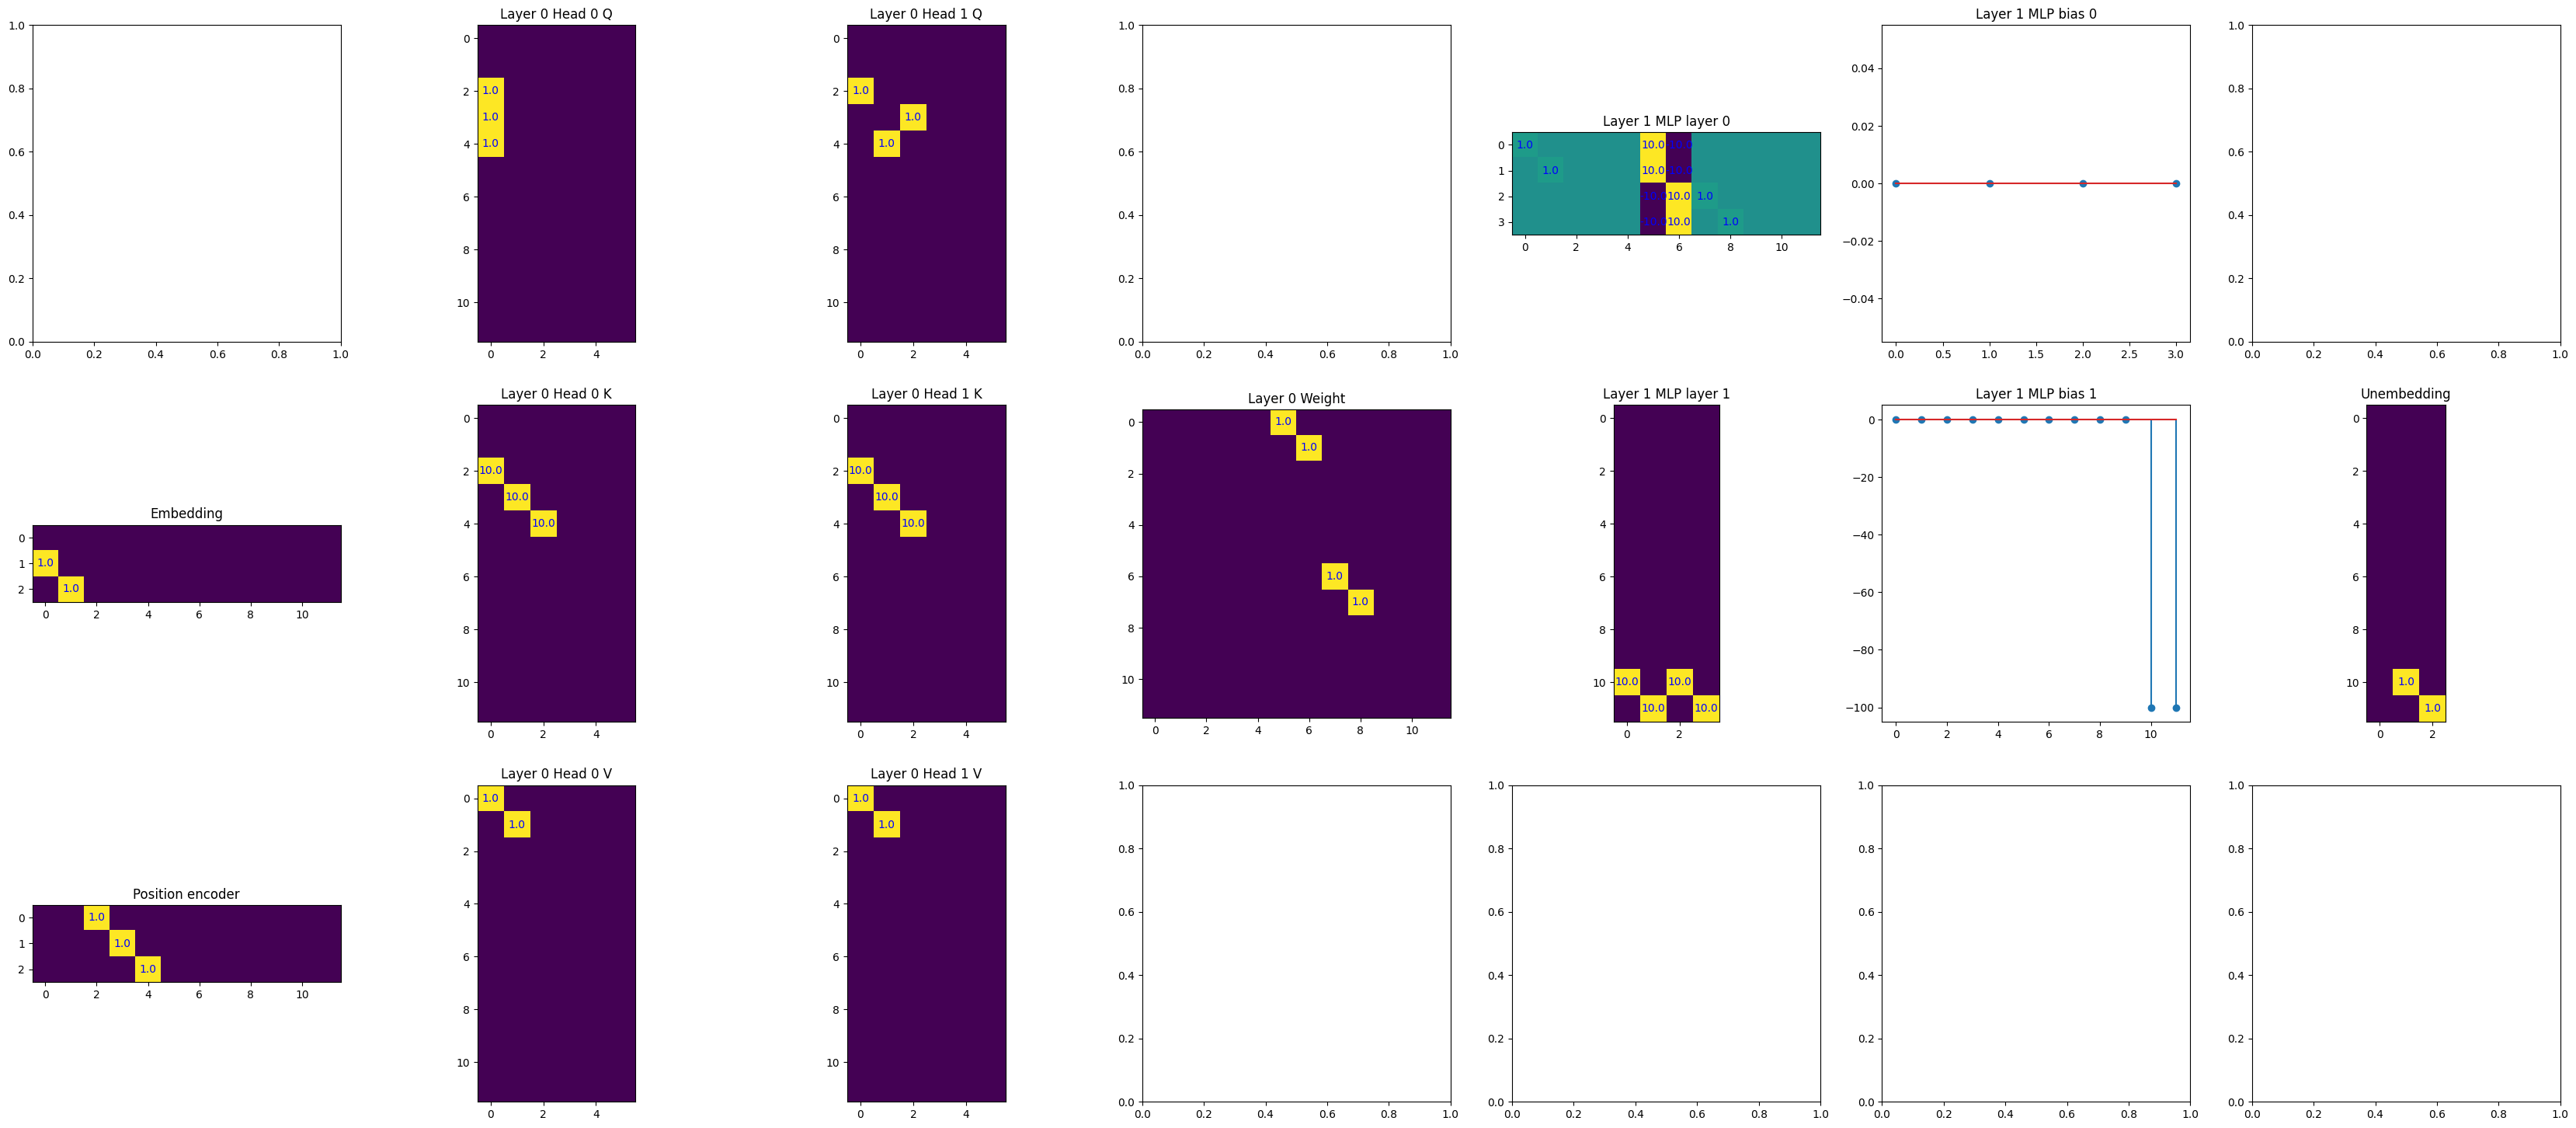

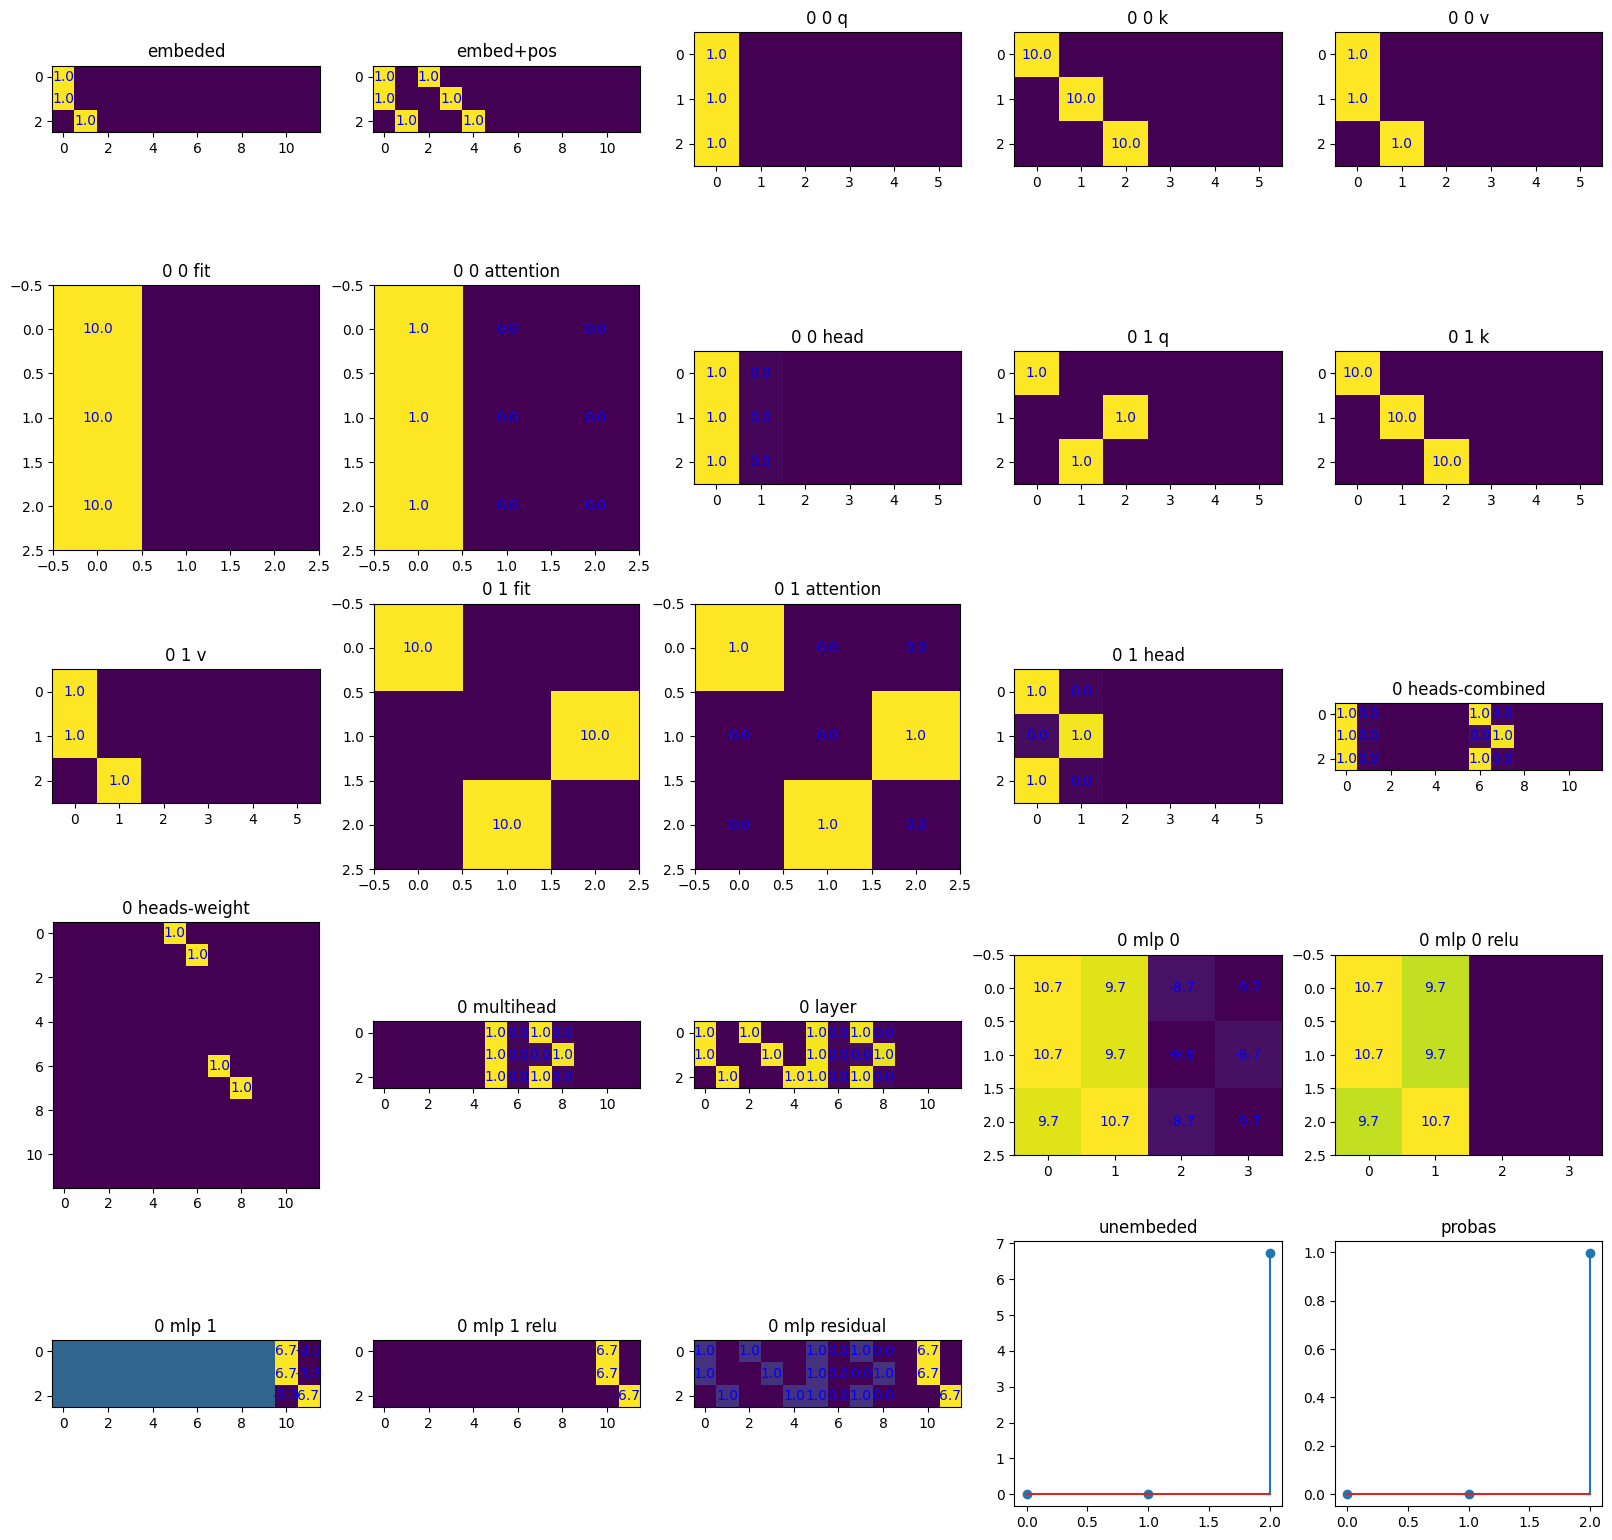

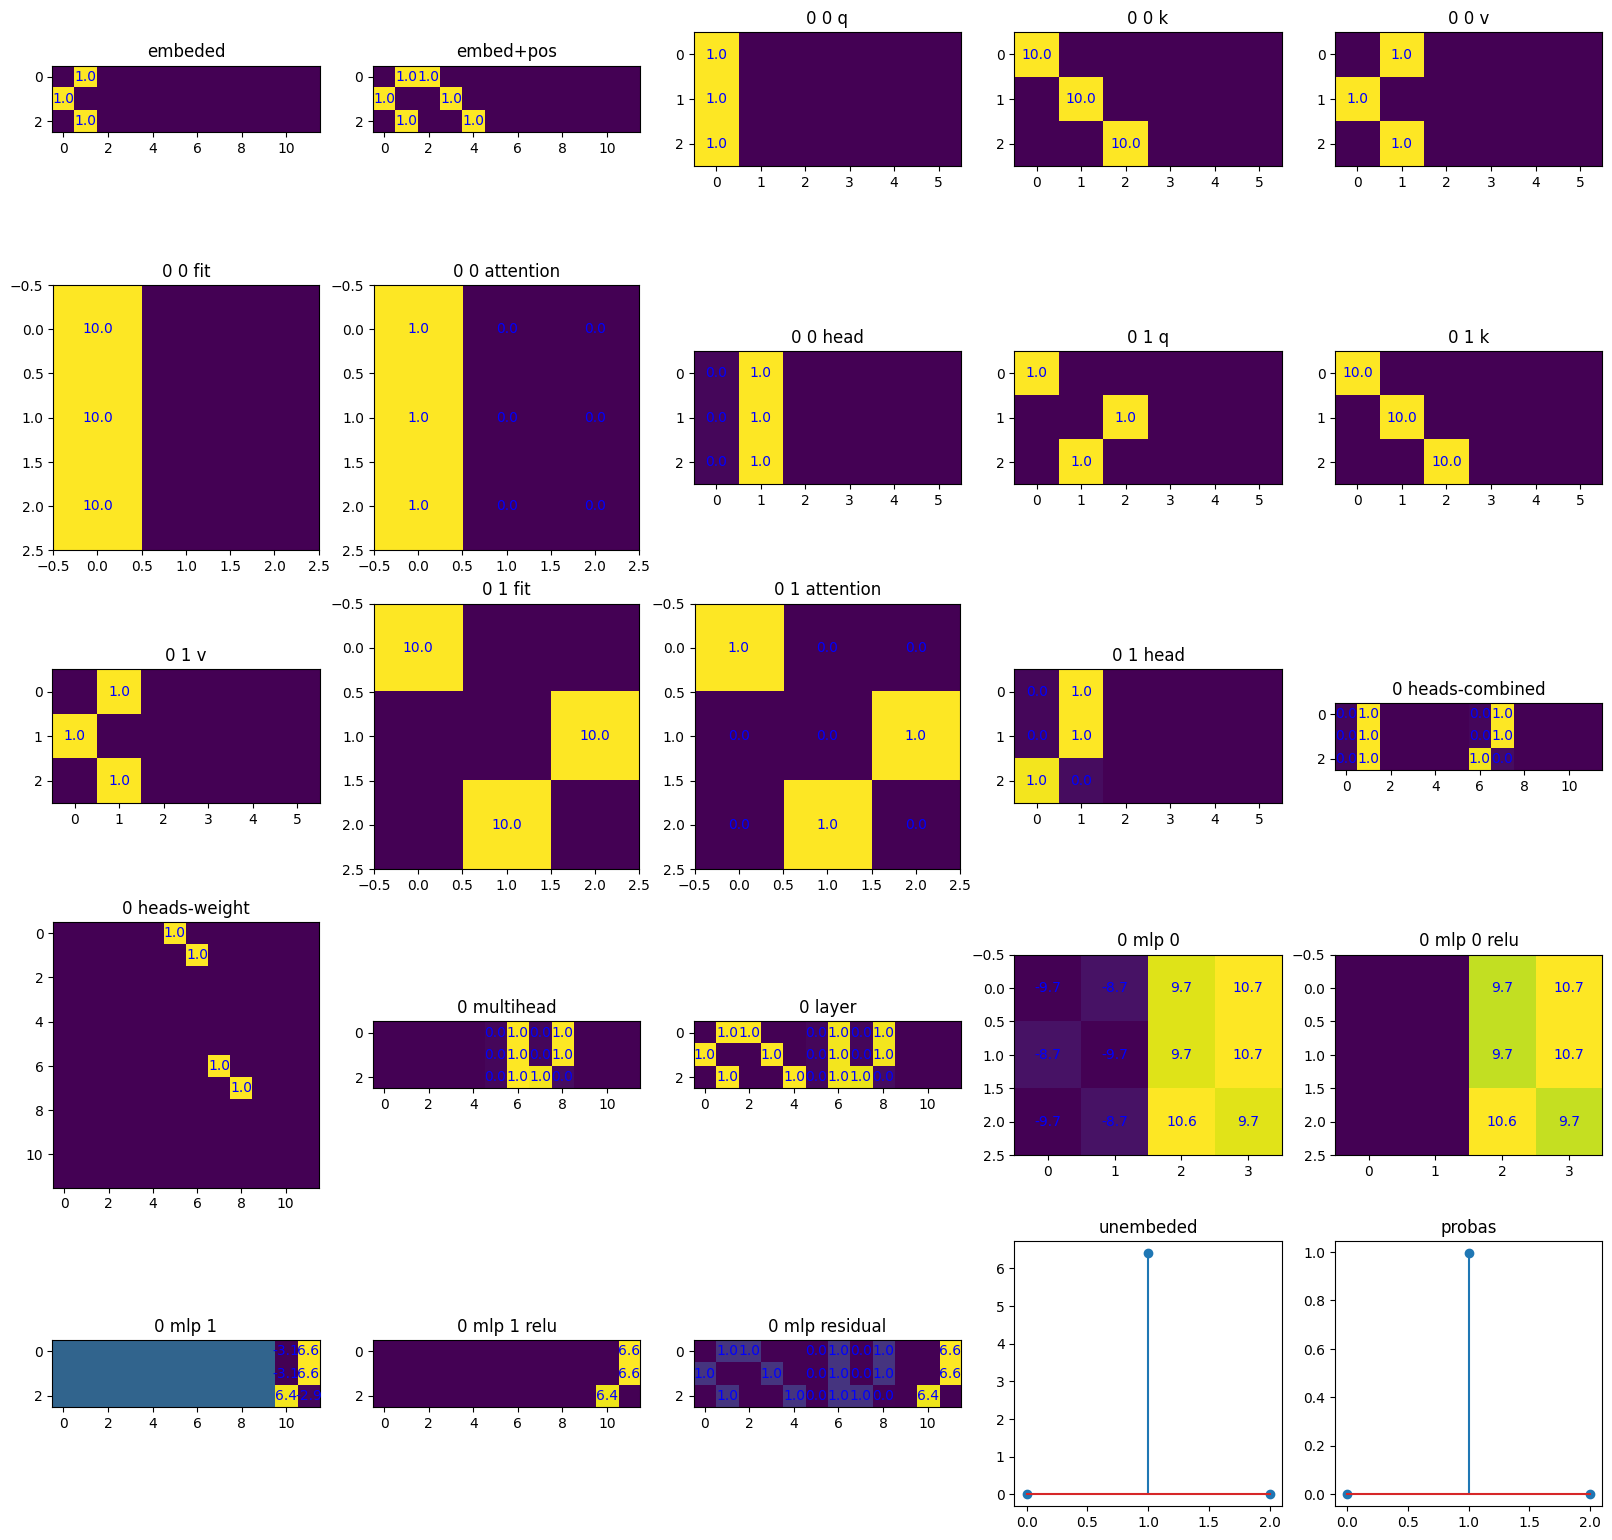

In [20]:
# from solutions.reverse import reverse_better as reverse
from solutions.if_then_else import if_then_else, EXO

print(EXO)

model = if_then_else()

set_debug()
show_transformer(model, scale=6)
show_activations(model, EXO.tokenizer.encode(["001"]))
show_activations(model, EXO.tokenizer.encode(["101"]))

EXO.test(model, 1000)


# Stability of the models

The goal here is to perturb the weight with a small amount of noise, then use SGD to see if the model can recover from the perturbation.

Things to experiment with:
- Intensity of the noise
- Distribution of the noise (propotional to the weight vs. constant vs. mix of the two)

In [84]:
from solutions.if_then_else import if_then_else, EXO

handmade = if_then_else()

average = 10
noise_levels = torch.linspace(0, 0.05, 100)
accuracy = []
for noise in noise_levels:
    acc = 0
    for _ in range(average):
        acc += EXO.test(perturb(handmade, noise), 100)[0]
    accuracy.append(acc / average)

010 → 0         	'': 0.00  0: 1.00  1: 0.00
001 → 1         	'': 0.00  0: 0.00  1: 1.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
101 → 0         	'': 0.00  0: 1.00  1: 0.00
101 → 0         	'': 0.00  0: 1.00  1: 0.00
001 → 1         	'': 0.00  0: 0.00  1: 1.00
111 → 1         	'': 0.00  0: 0.00  1: 1.00
110 → 1         	'': 0.00  0: 0.00  1: 1.00
111 → 1         	'': 0.00  0: 0.00  1: 1.00
011 → 1         	'': 0.03  0: 0.03  1: 0.94
Loss: 0.56  Accuracy: 100 / 100
010 → 0         	'': 0.00  0: 1.00  1: 0.00
111 → 1         	'': 0.00  0: 0.00  1: 1.00
111 → 1         	'': 0.00  0: 0.00  1: 1.00
001 → 1         	'': 0.00  0: 0.00  1: 1.00
010 → 0         	'': 0.00  0: 1.00  1: 0.00
101 → 0         	'': 0.00  0: 1.00  1: 0.00
101 → 0         	'': 0.00  0: 1.00  1: 0.00
111 → 1         	'': 0.00  0: 0.00  1: 1.00
000 → 0         	'': 0.00  0: 1.00  1: 0.00
101 → 0         	'': 0.00  0: 1.00  1: 0.00
Loss: 0.56  Accuracy: 100 / 100
100 → 0         	'': 0.03  0: 0.93  1: 0.03
111 → 1     

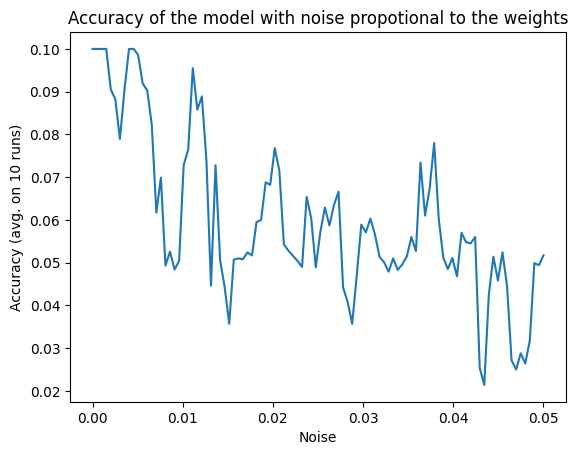

In [85]:
# Plot accuracy vs noise
plt.plot(noise_levels, torch.Tensor(accuracy) / 1000)
plt.xlabel("Noise")
plt.ylabel(f"Accuracy (avg. on {average} runs)")
plt.title("Accuracy of the model with noise propotional to the weights")
plt.show()


Mistakes:
101 -> '0' (predicted '1')
001 -> '1' (predicted '')
000 -> '0' (predicted '')
011 -> '1' (predicted '')
010 -> '0' (predicted '')
100 -> '0' (predicted '1')


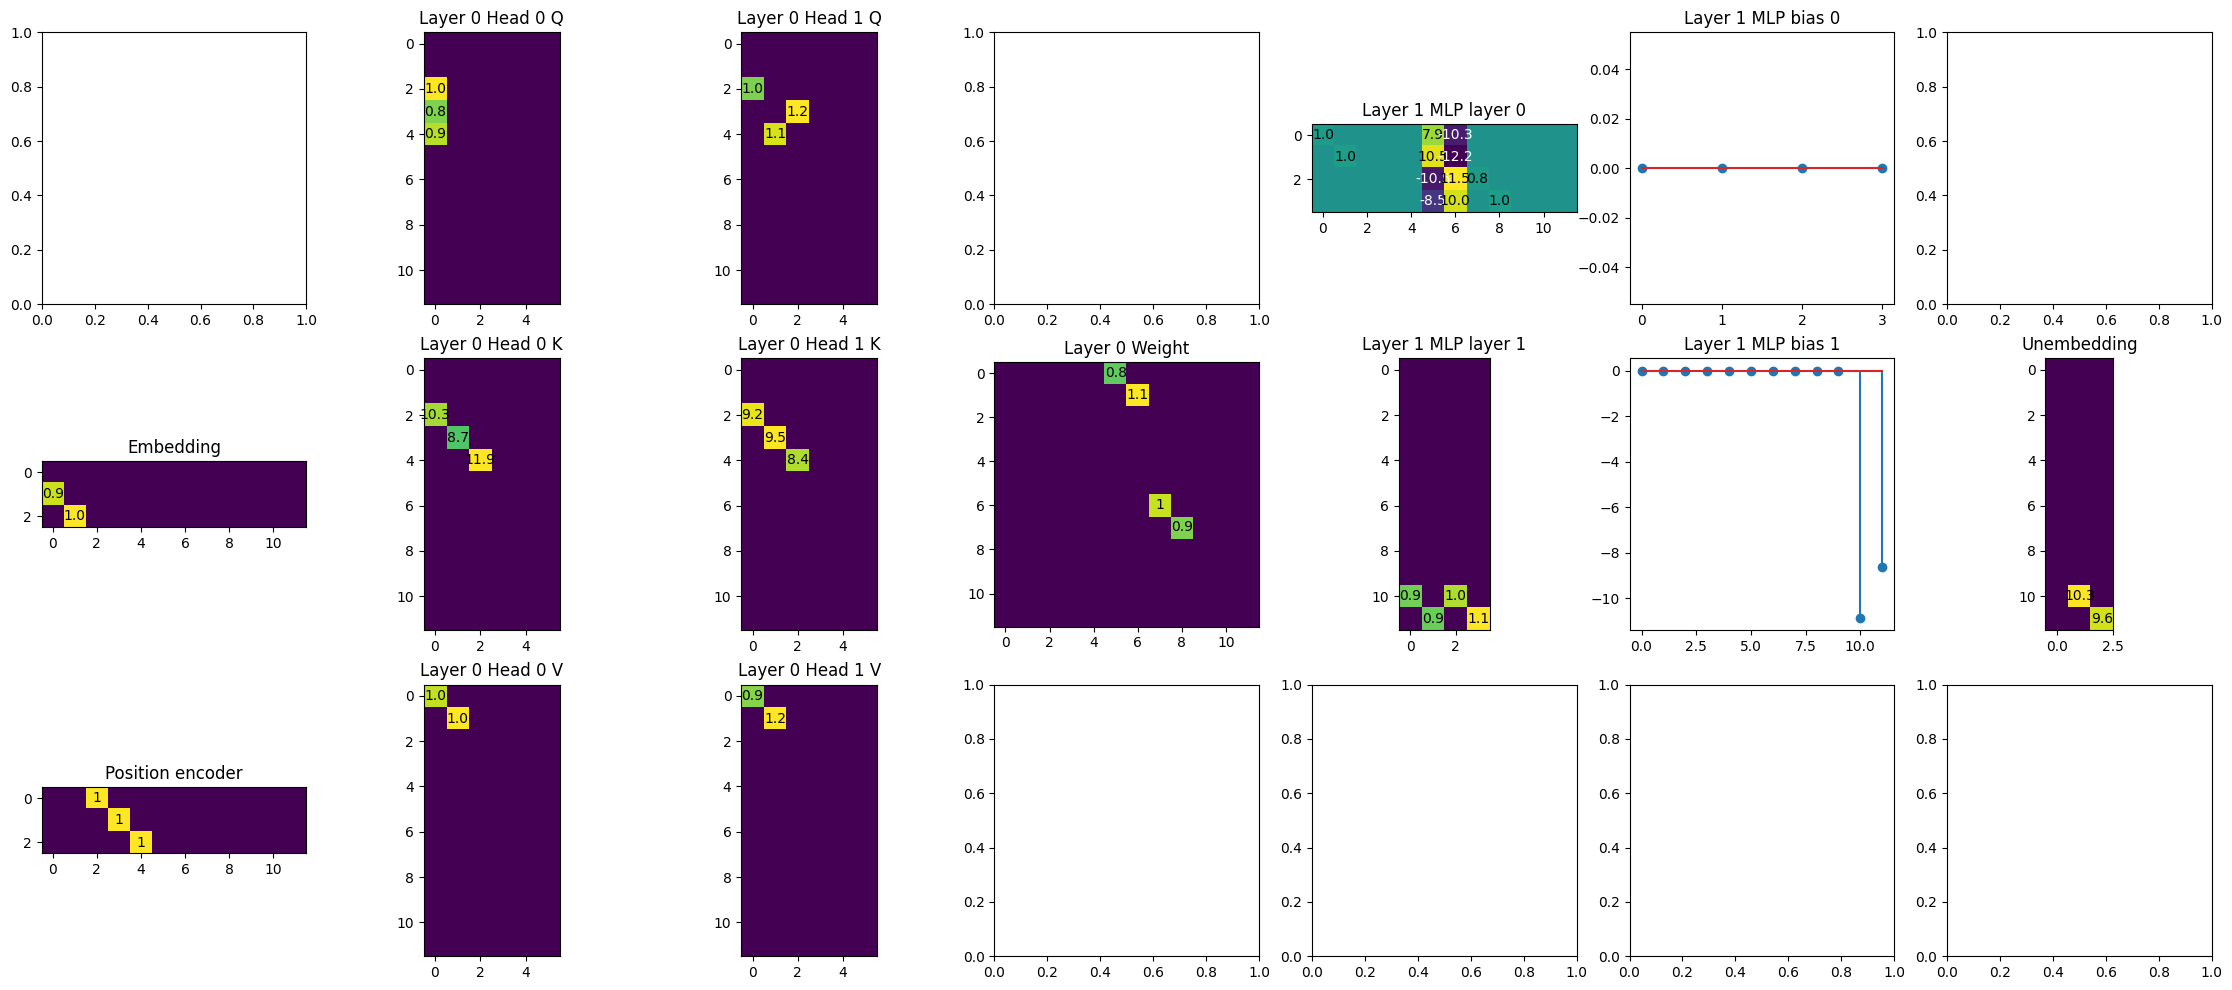

In [88]:
# Inspecting a model that does not work because of noise 
while True:
    model = perturb(if_then_else(), 0.1)
    if EXO.test(model, 1000, verbose=False)[0] < 1000:
        break

show_transformer(model)

print("Mistakes:")
for x, correct, predicted in EXO.mistakes(model):
    print(f"{x} -> {correct!r} (predicted {predicted!r})")

Prompt: 101


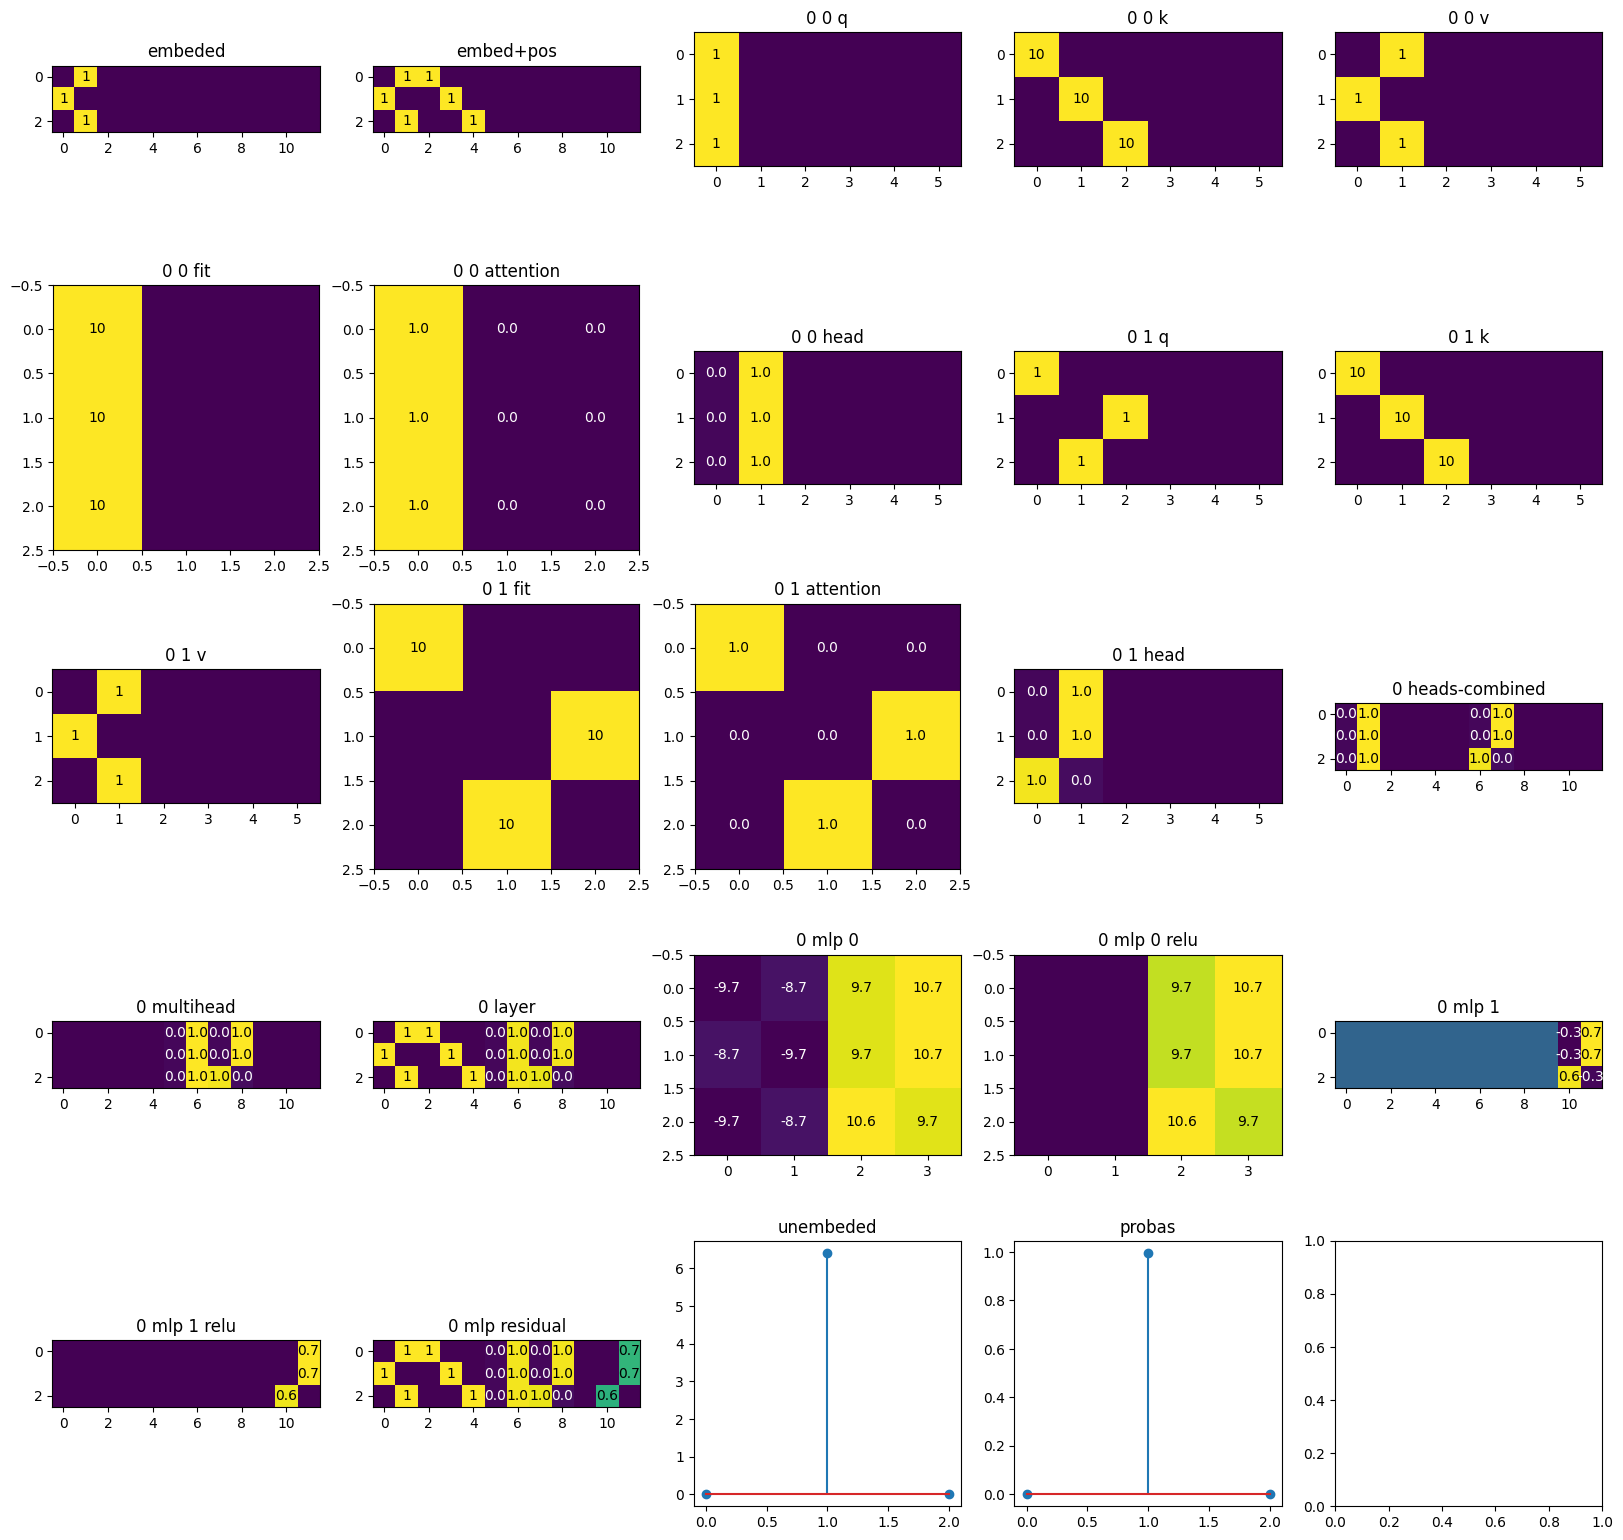

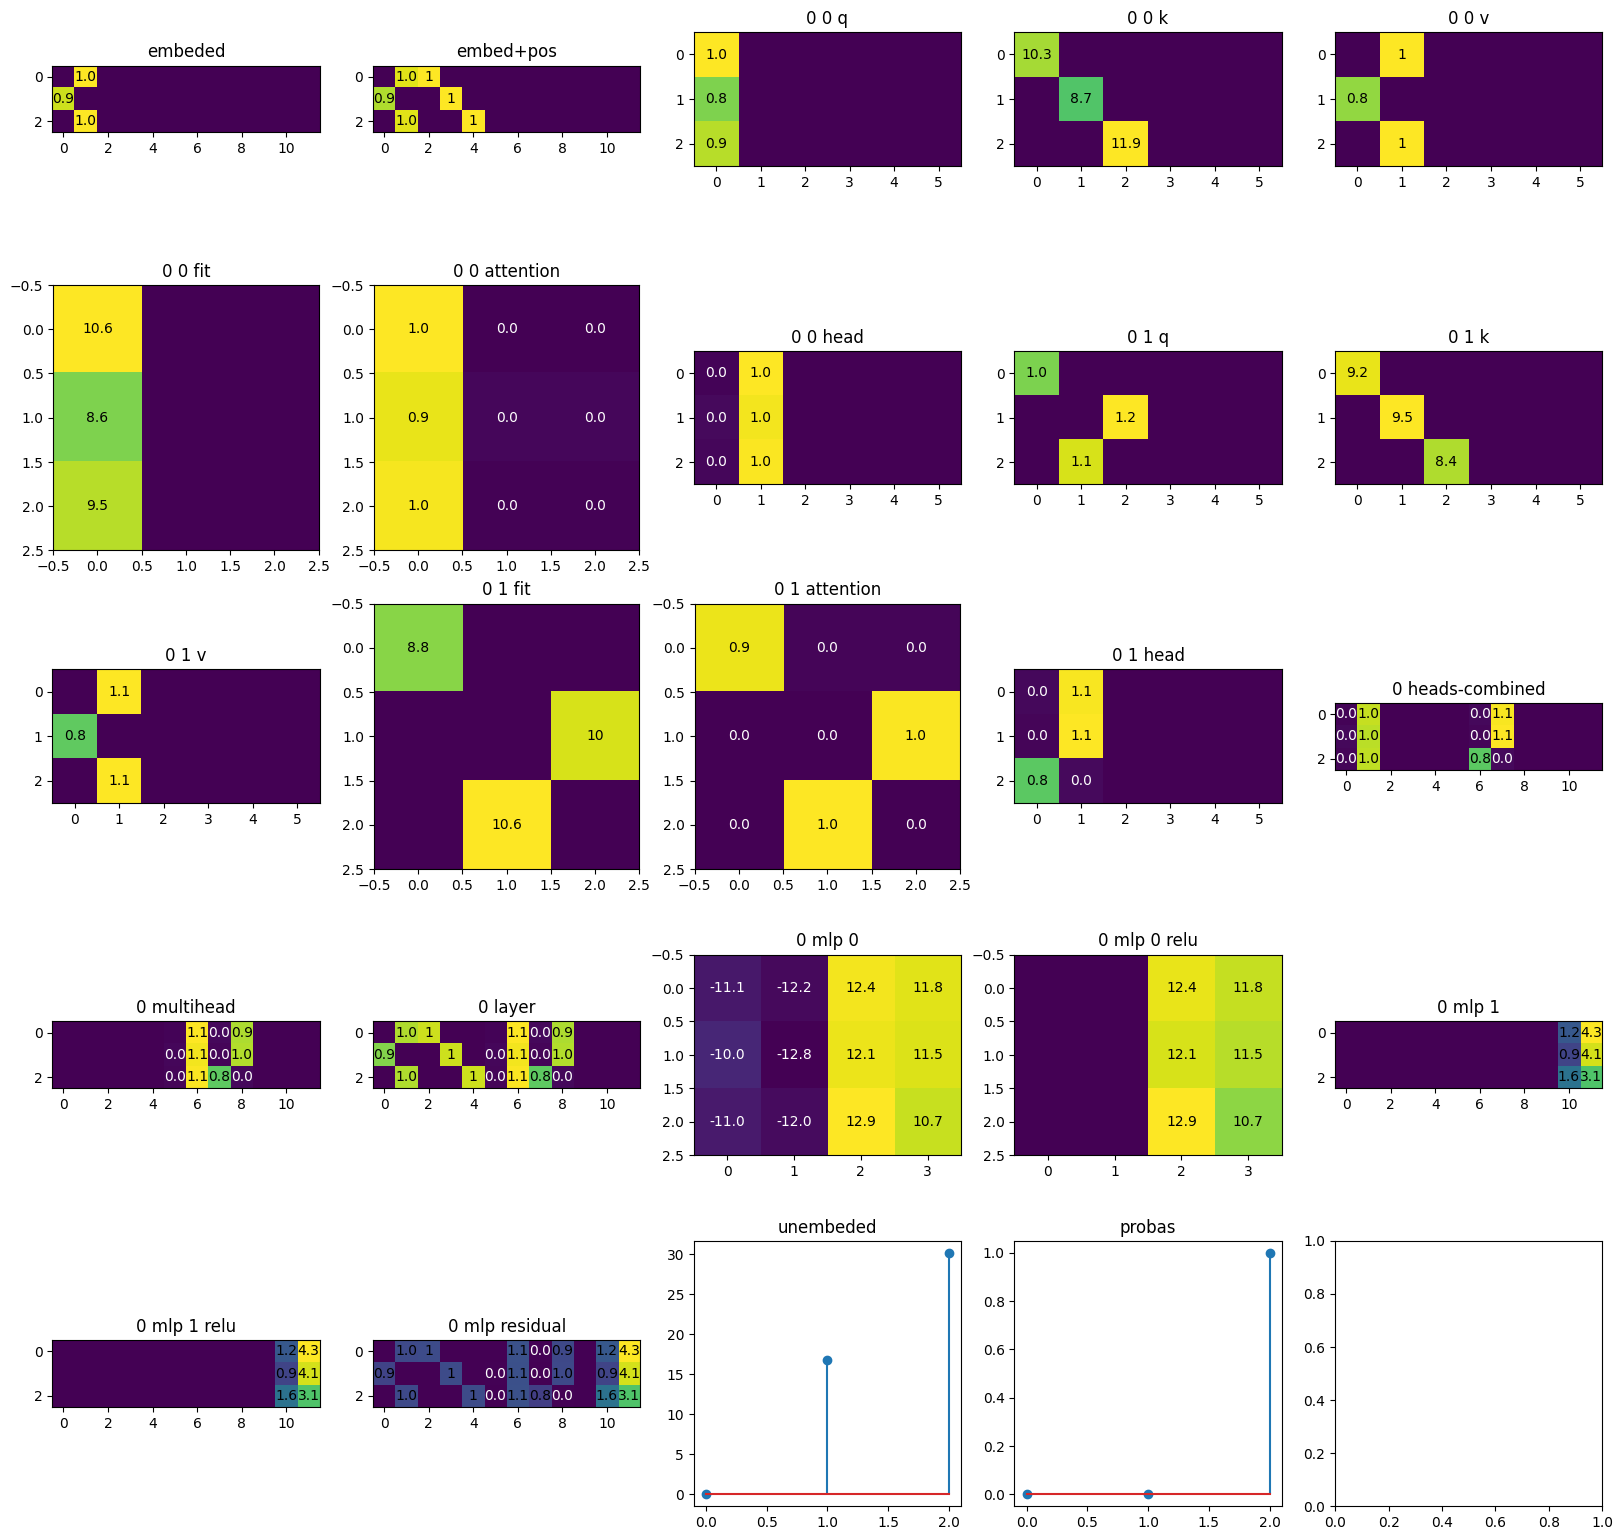

In [89]:
# pick a prompt from the mistake set
prompt = random.choice(list(EXO.mistakes(model)))
prompt = '101'
print("Prompt:", prompt)
prompt_encoded = EXO.tokenizer.encode([prompt])
show_activations(if_then_else(), prompt_encoded)
show_activations(model, prompt_encoded)

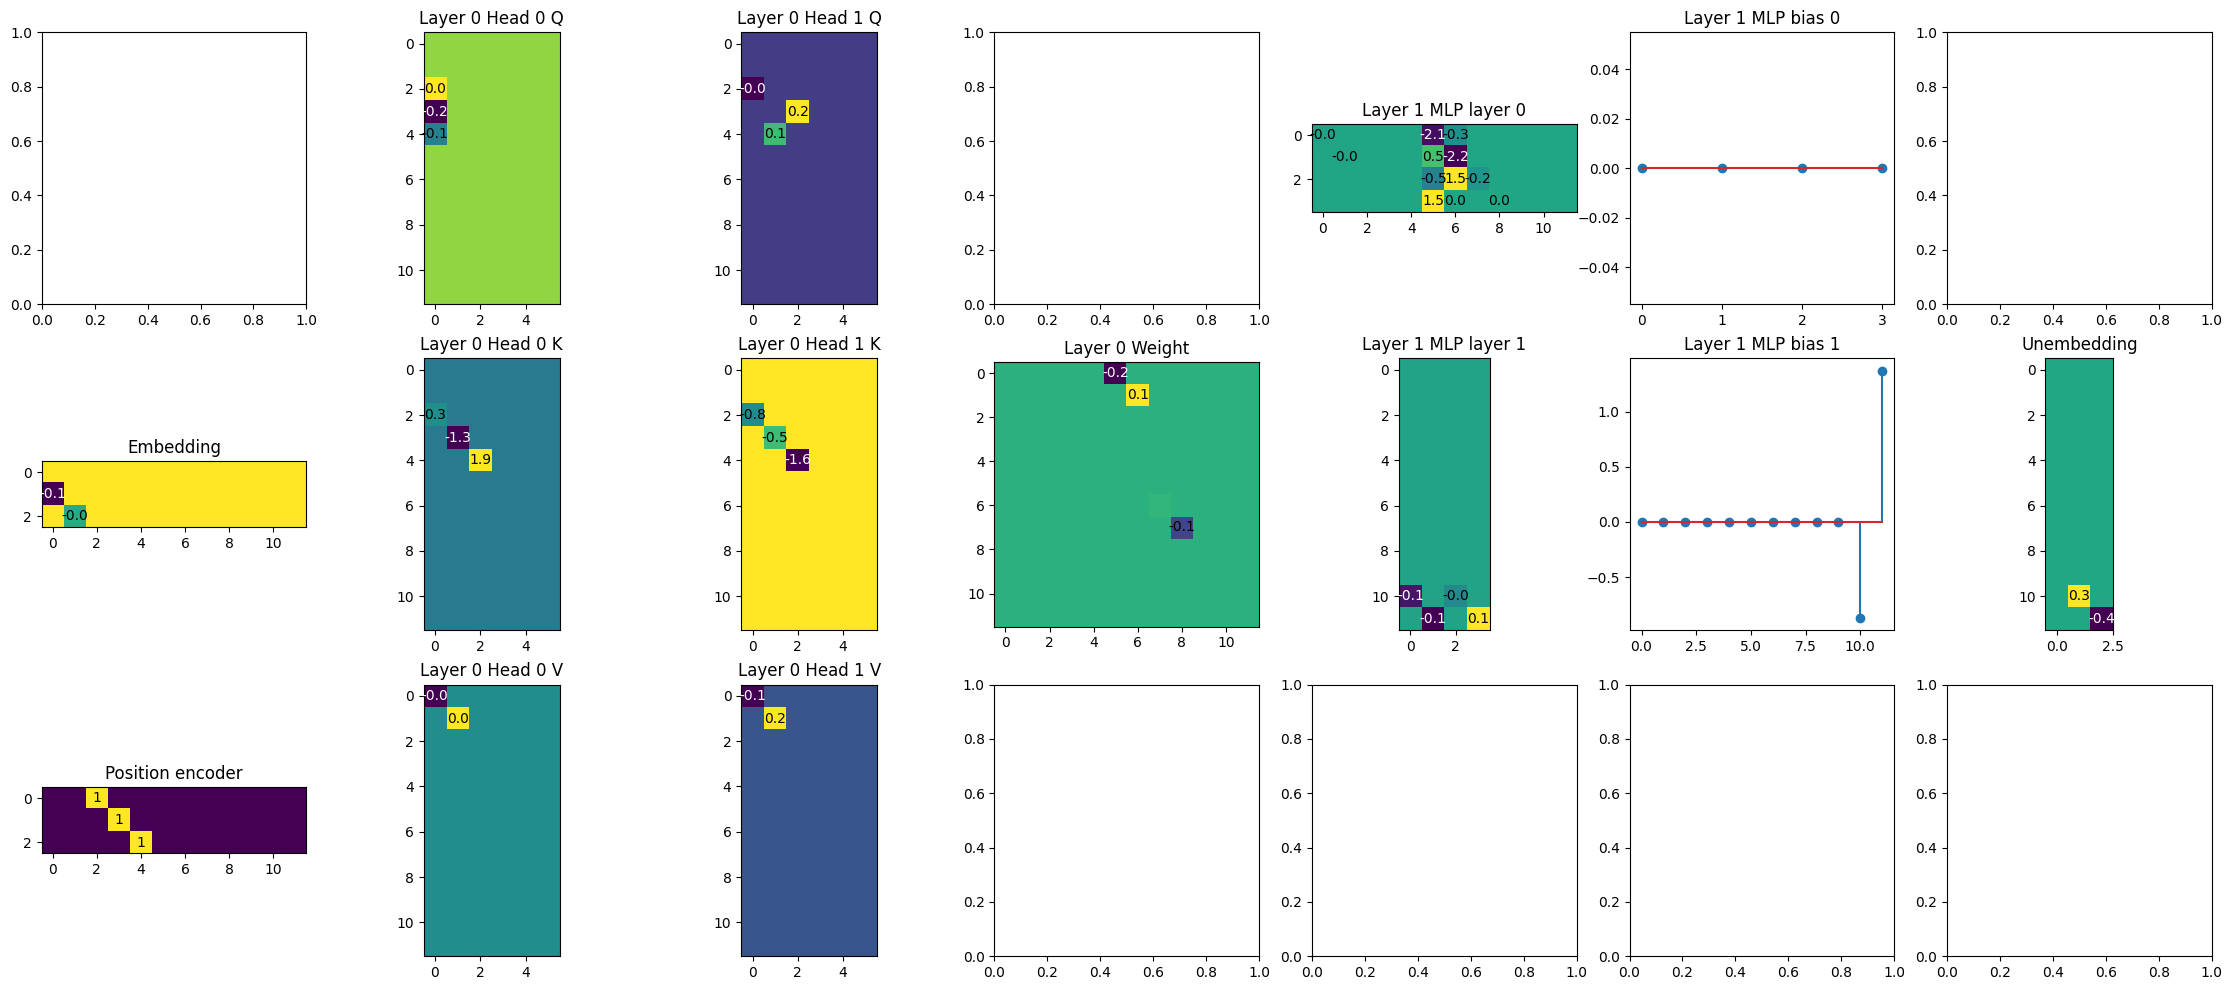

In [91]:
diff = model_diff(if_then_else(), model)
show_transformer(diff)

Now that we have a few examples of how things don't work, we check wether SGD can recover from a perturbation of the weight.

In [155]:
model = perturb(if_then_else(), 0.3)
data = train(model, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 loss: 1.0514447689056396
Epoch 20 loss: 1.0514447689056396
Epoch 40 loss: 1.0514447689056396
Epoch 60 loss: 1.0514447689056396
Epoch 80 loss: 1.0514447689056396
Epoch 100 loss: 1.0514447689056396
Epoch 120 loss: 1.0514447689056396
Epoch 140 loss: 1.0514447689056396
Epoch 160 loss: 1.0514447689056396
Epoch 180 loss: 1.0514447689056396
Epoch 200 loss: 1.0514447689056396


In [158]:
data = train(model, data=data)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 loss: 1.0514447689056396
Epoch 10 loss: 1.0514447689056396
Epoch 20 loss: 1.0514447689056396
Epoch 30 loss: 1.0514447689056396
Epoch 40 loss: 1.0514447689056396
Epoch 50 loss: 1.0514447689056396
Epoch 60 loss: 1.0514447689056396
Epoch 70 loss: 1.0514447689056396
Epoch 80 loss: 1.0514447689056396
Epoch 90 loss: 1.0514447689056396
Epoch 100 loss: 1.0514447689056396


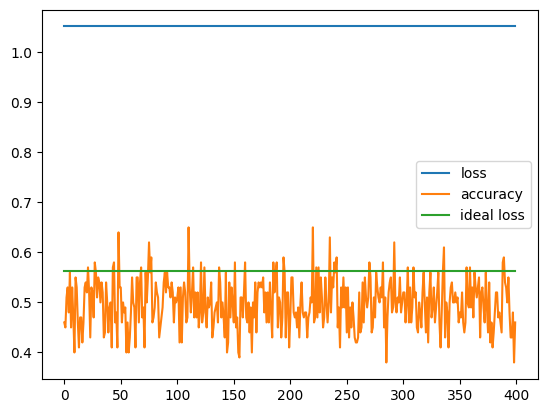

In [159]:
# Plot the evolution of the loss
ideal_loss = EXO.test(if_then_else(), 1000, verbose=False)[1]
plt.plot(data.loss, label="loss")
plt.plot(np.array(data.accuracy) / 100, label="accuracy")
plt.plot(np.ones_like(data.loss) * ideal_loss, label="ideal loss")
plt.legend()

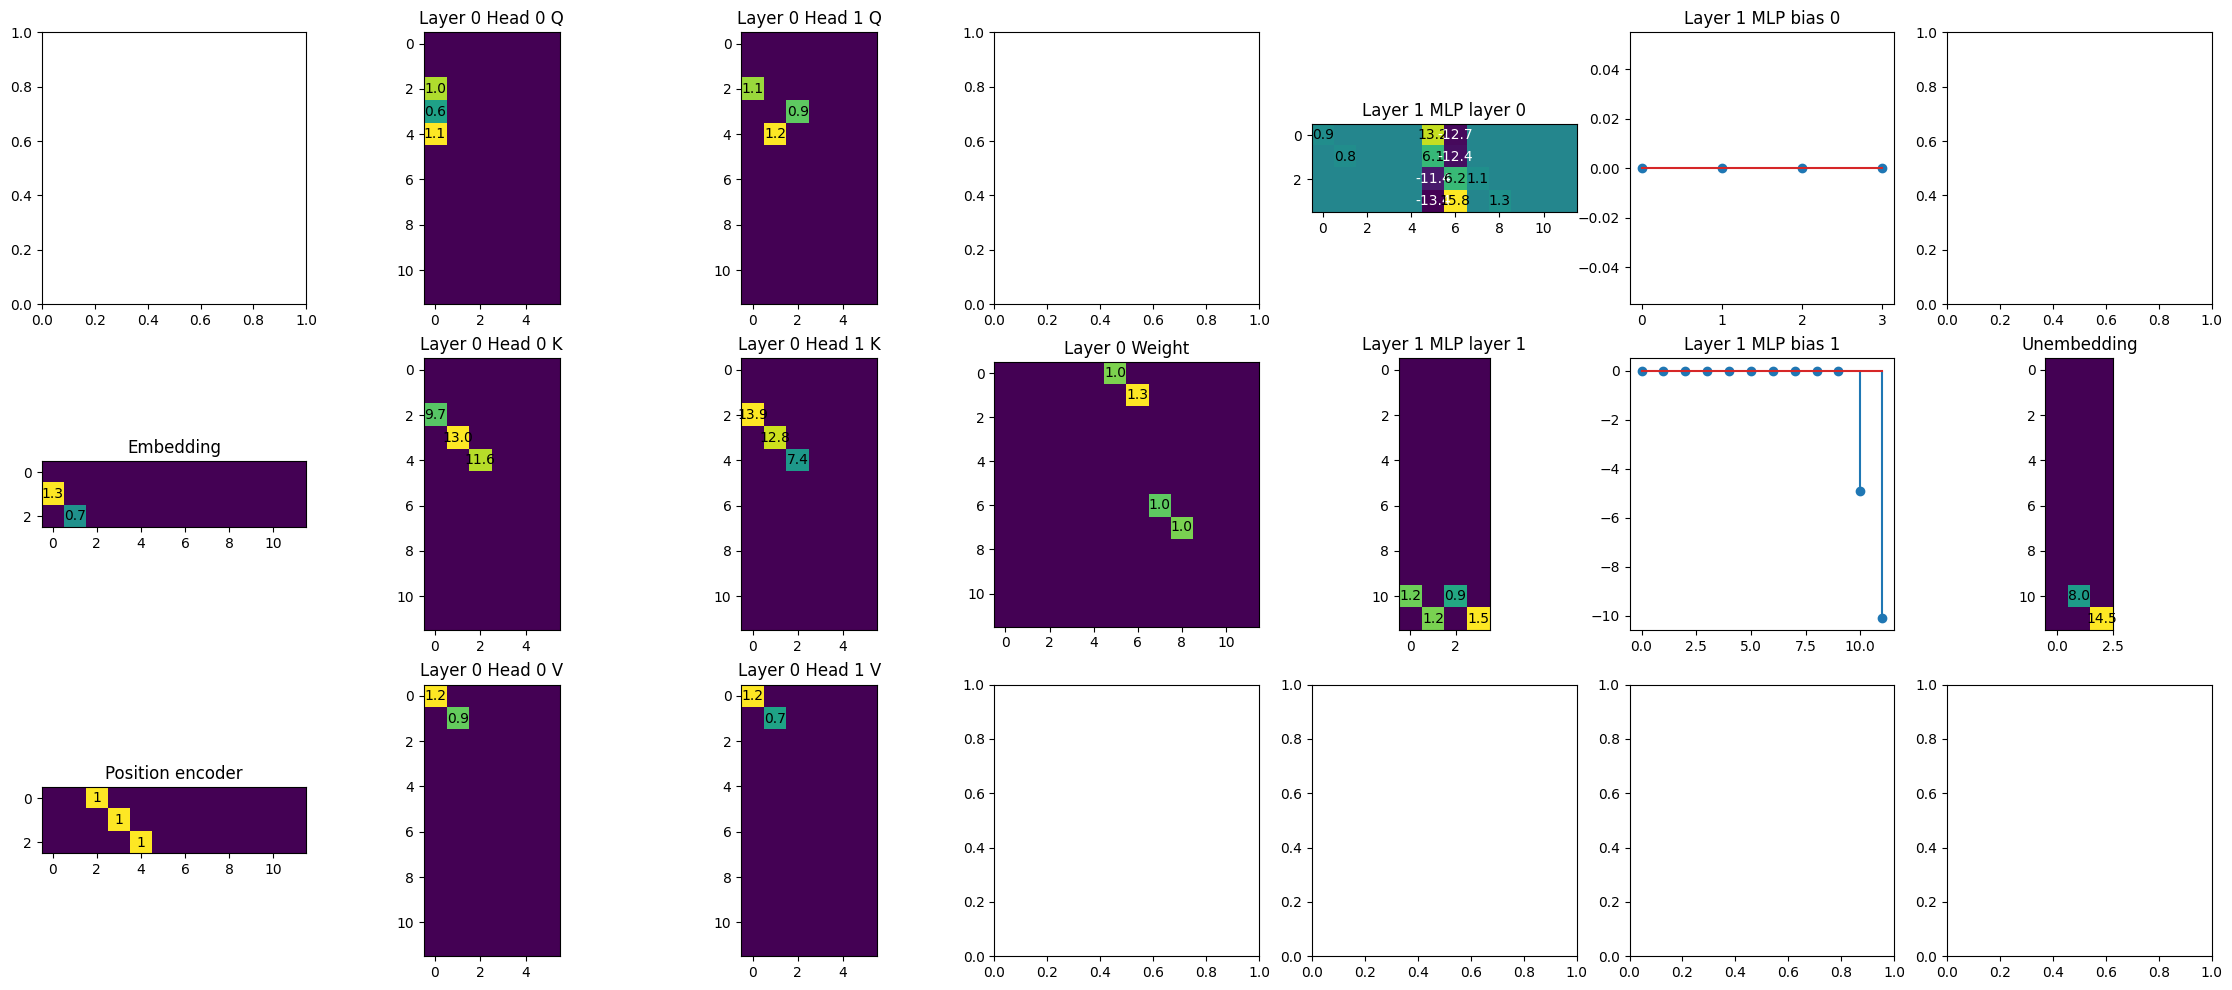

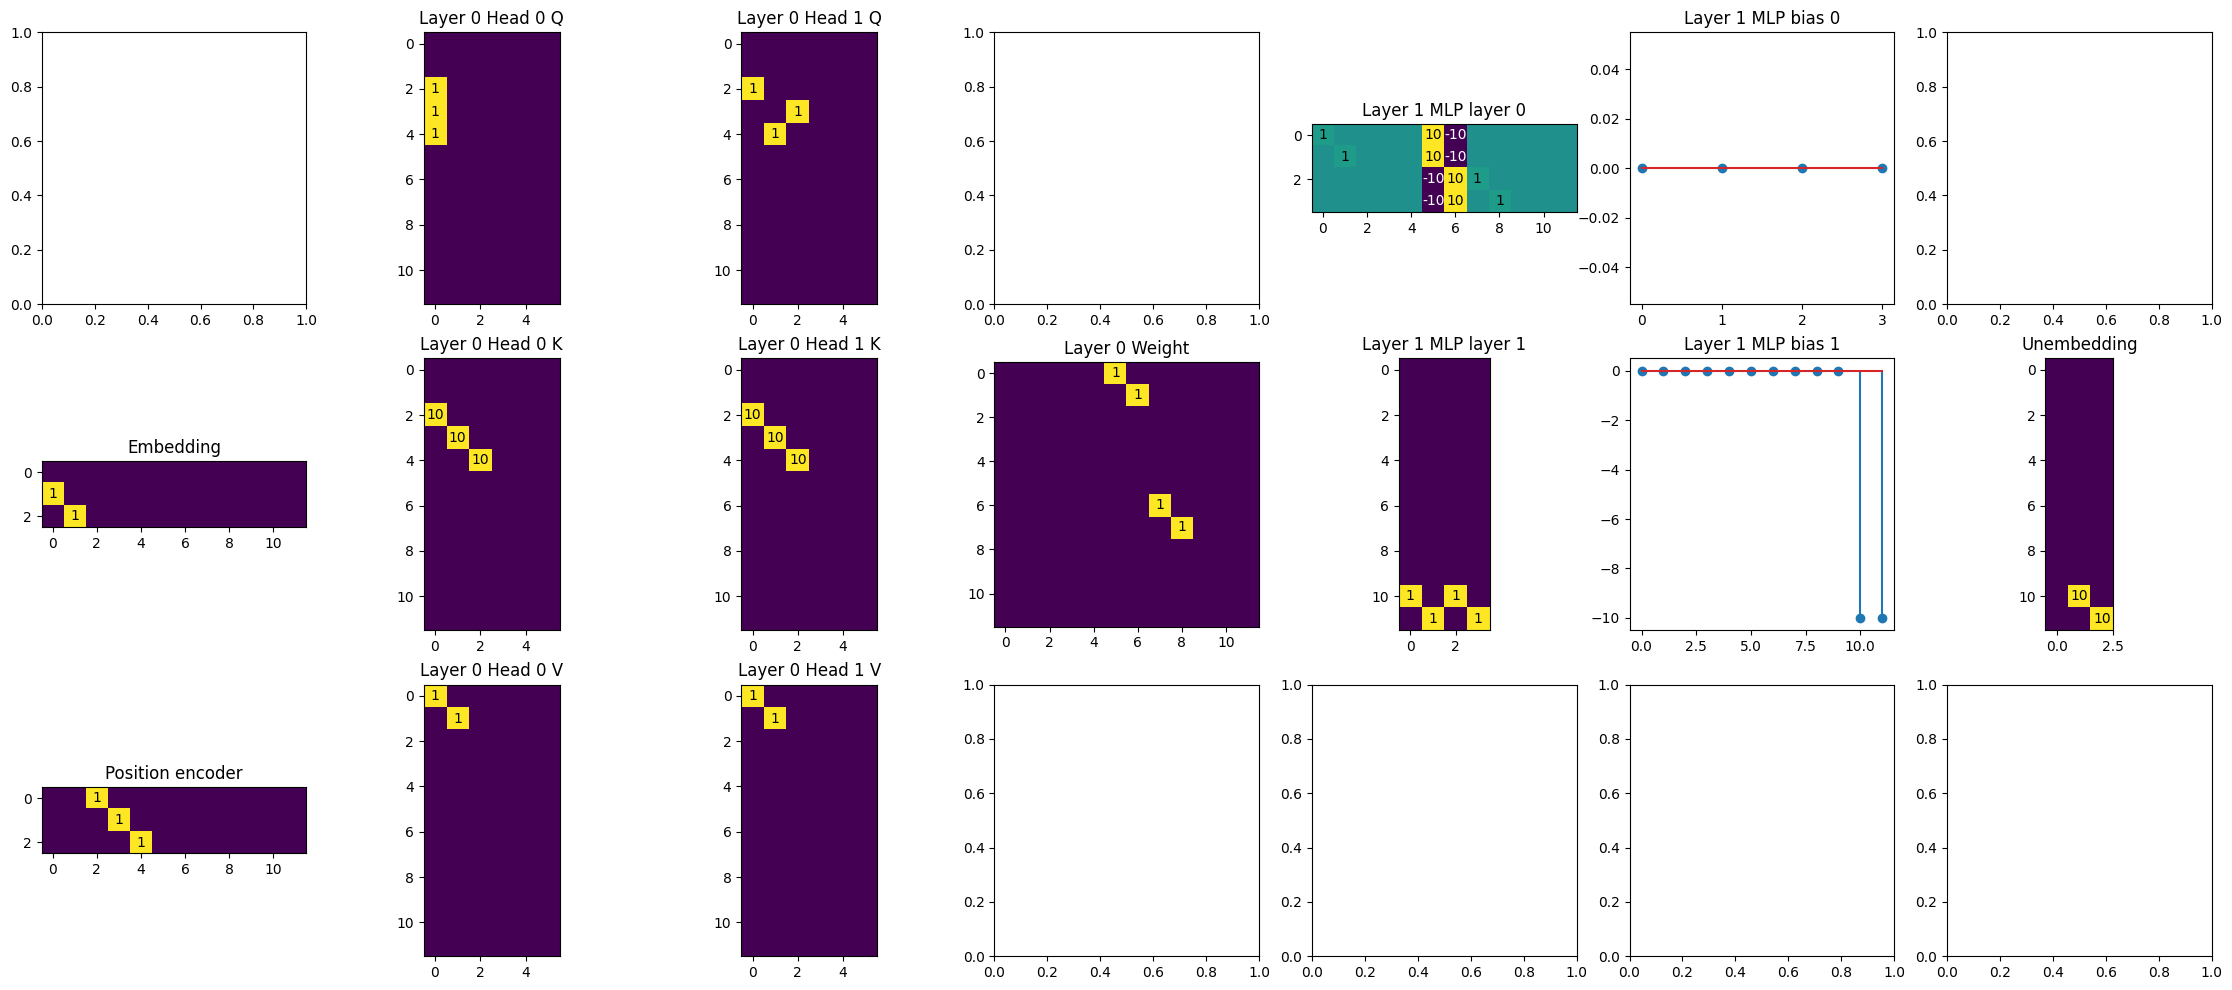

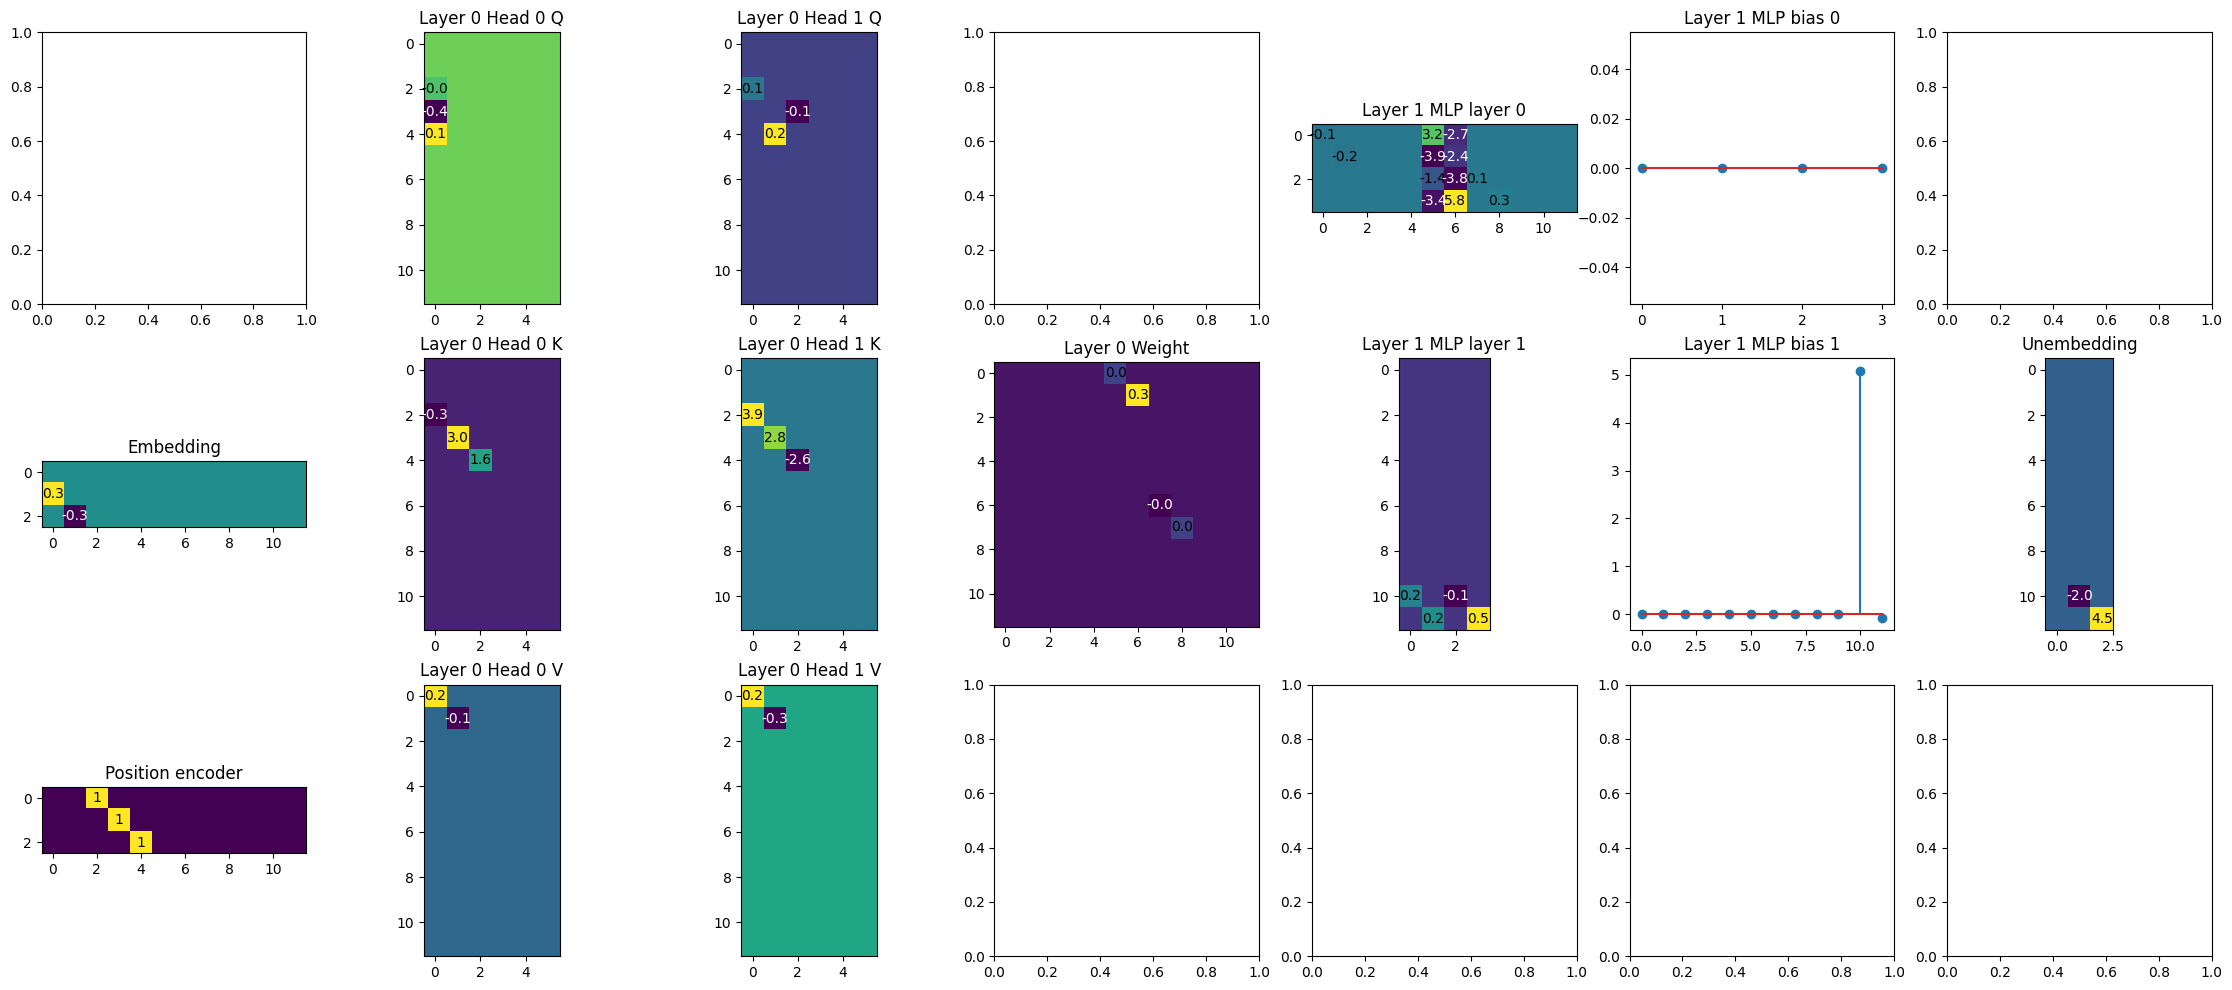

In [160]:
show_transformer(model)
show_transformer(if_then_else())
show_transformer(model_diff(if_then_else(), model))

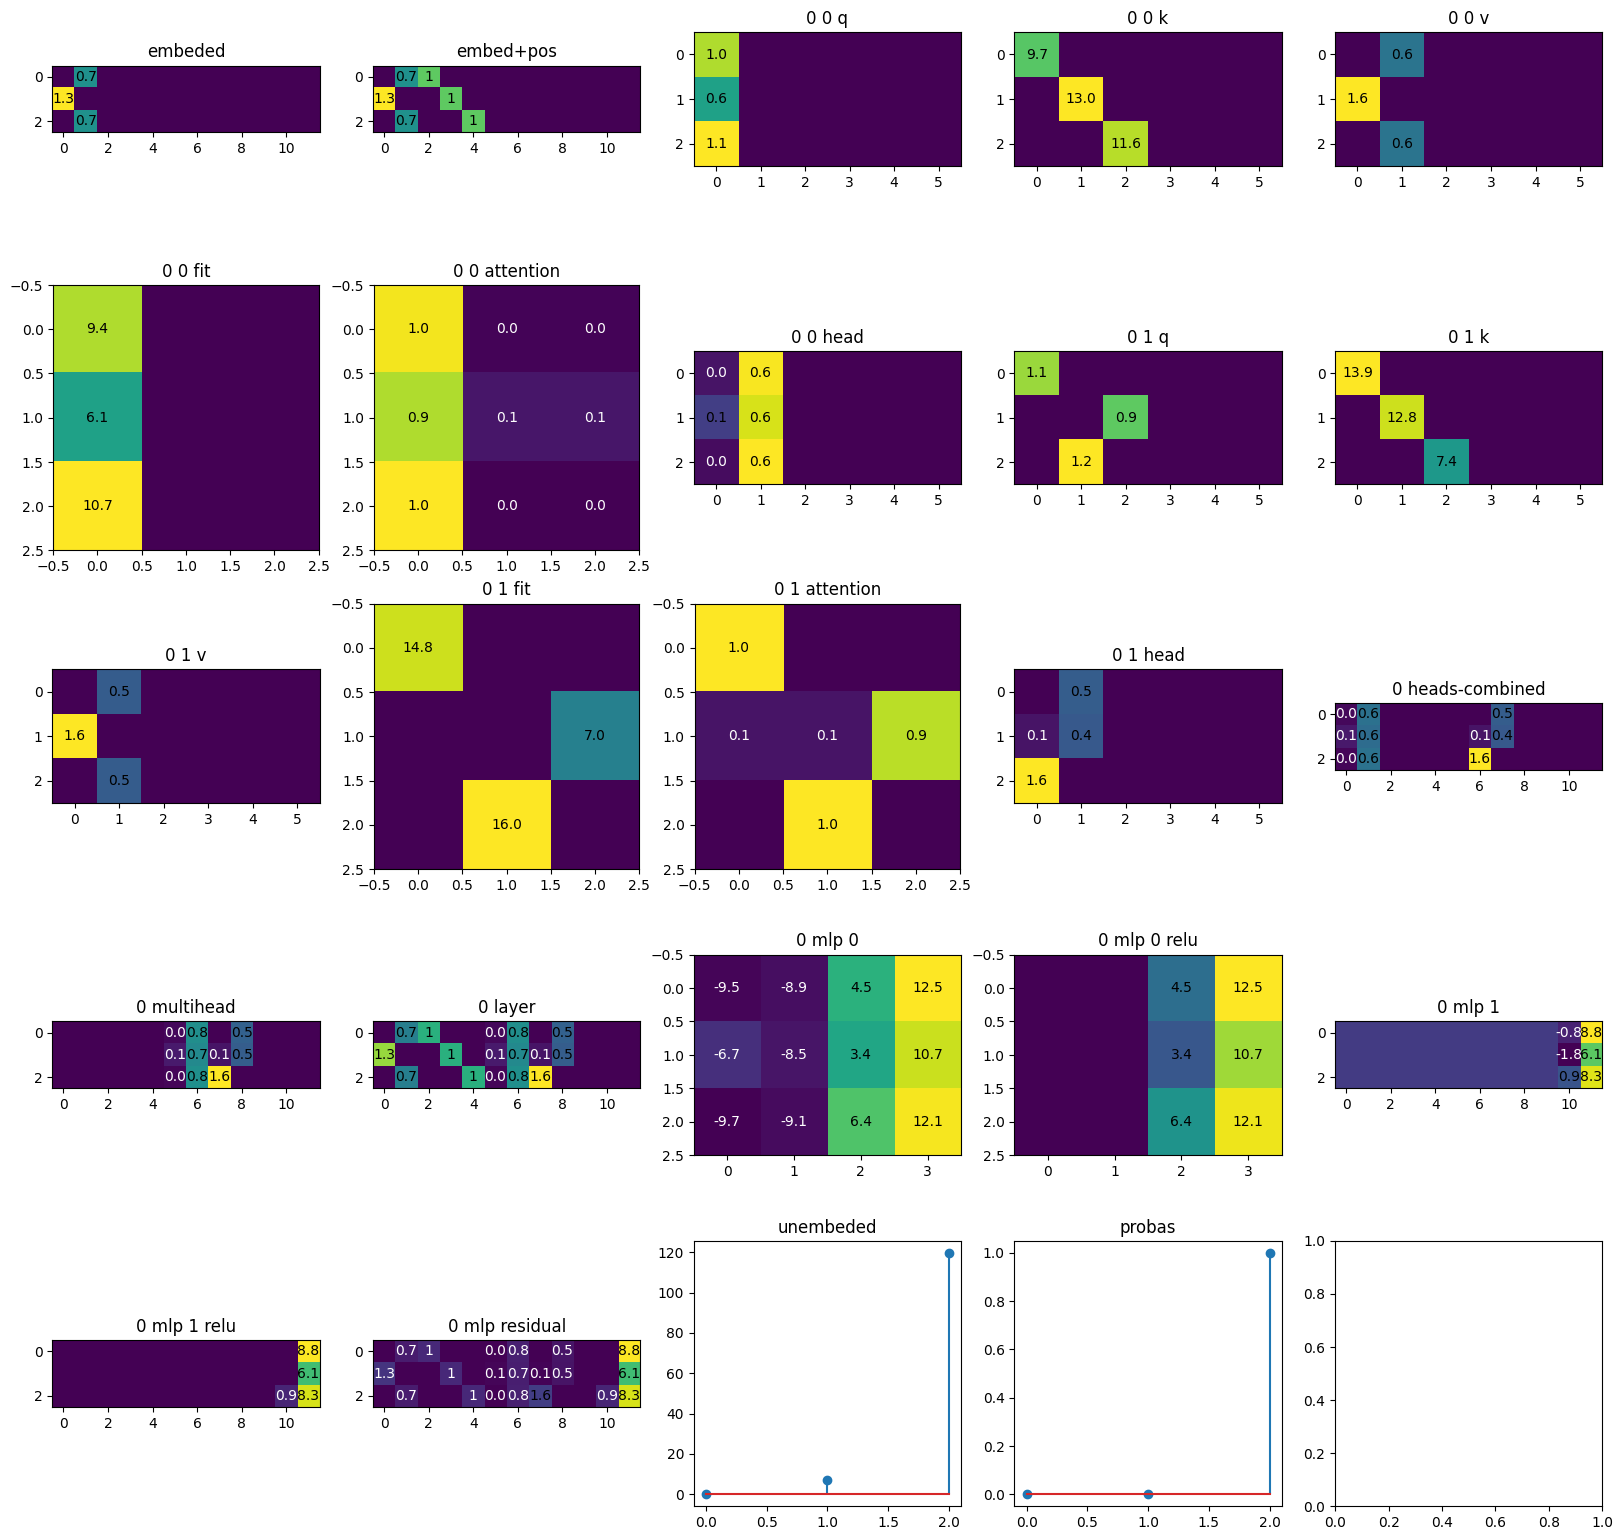

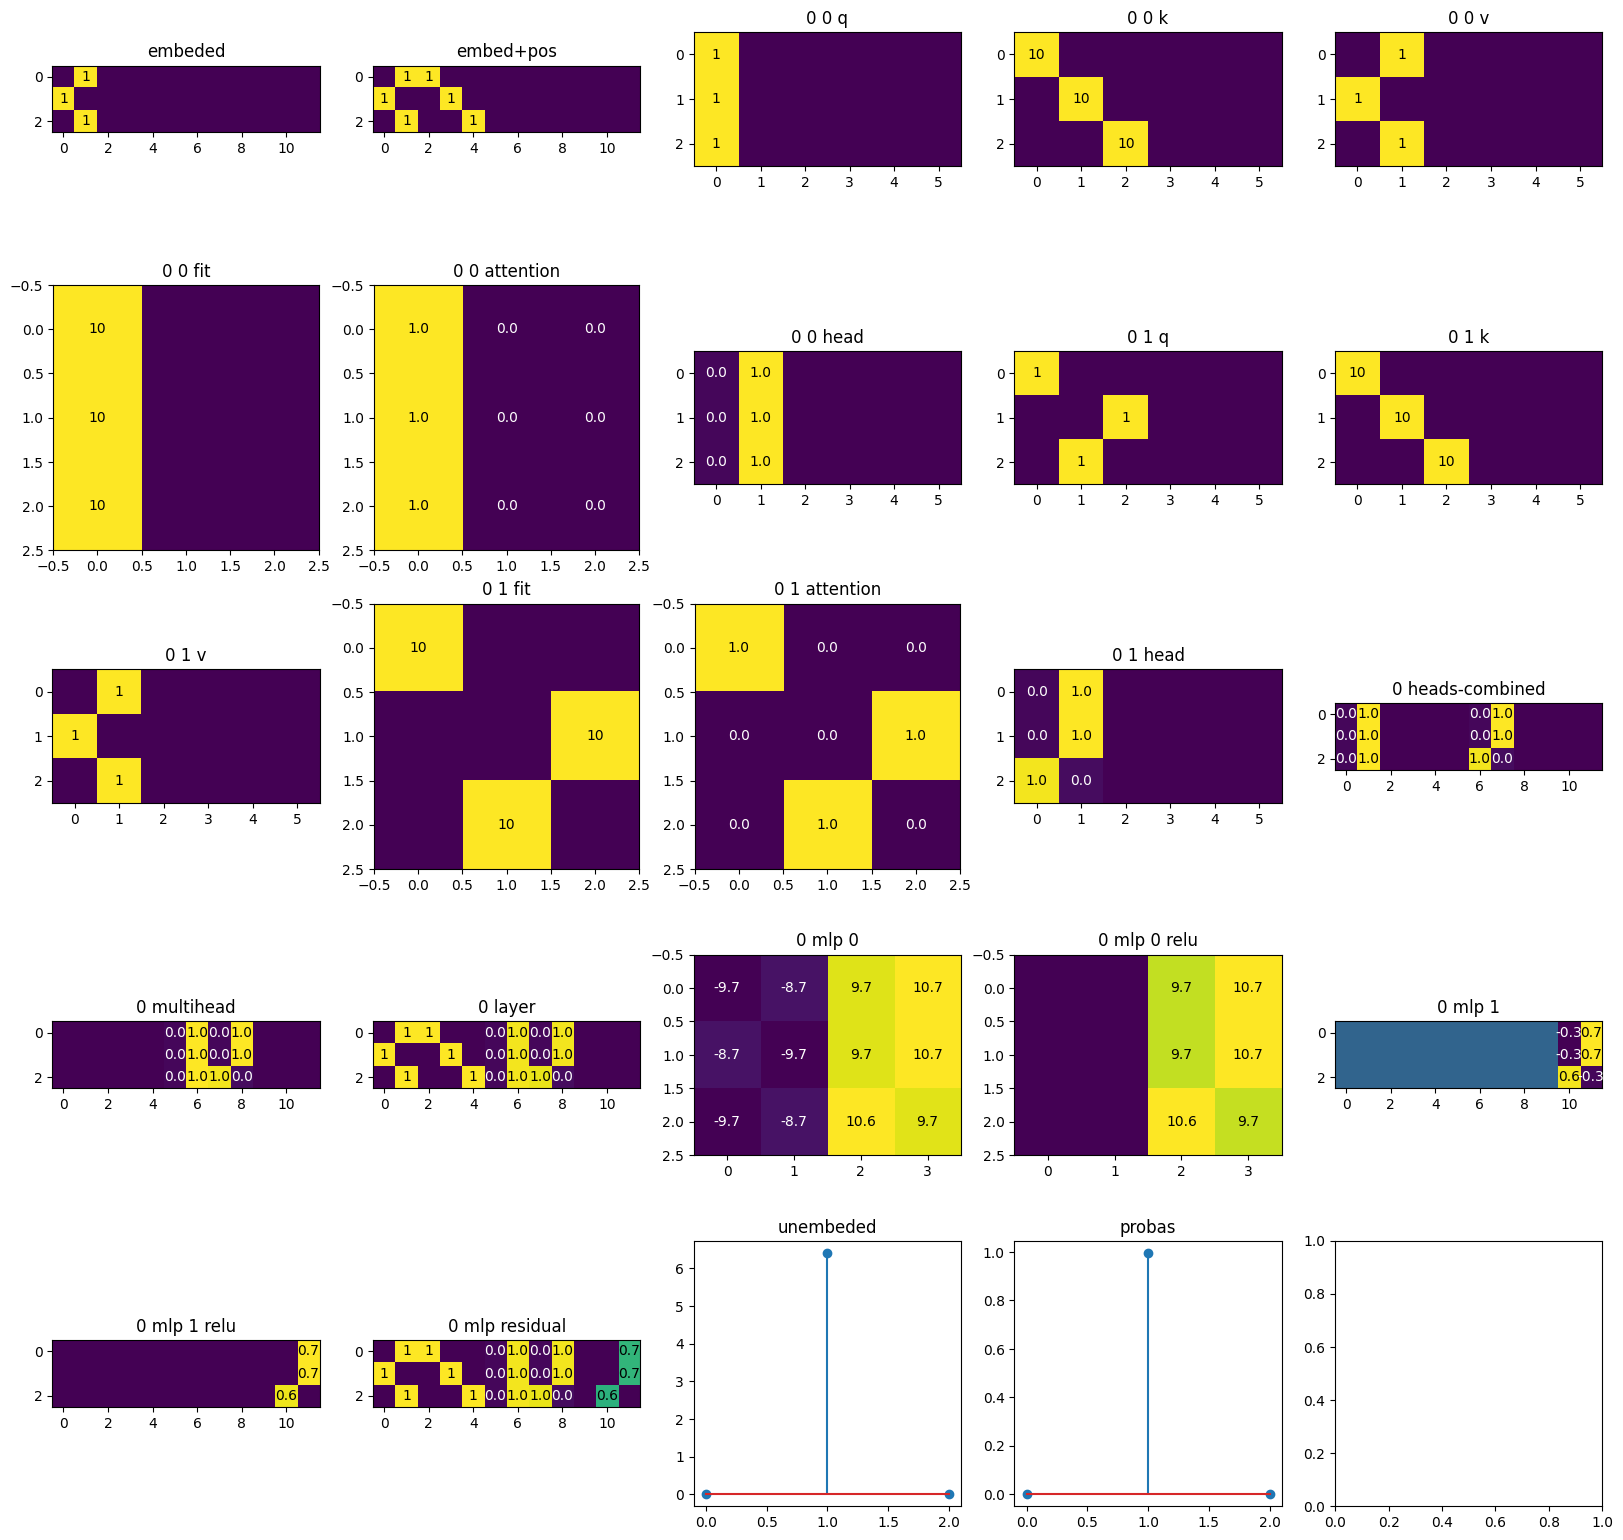

In [162]:
prompt = "101"
prompt_encoded = EXO.tokenizer.encode([prompt])
show_activations(model, prompt_encoded)
show_activations(if_then_else(), prompt_encoded)

# Tests

In [134]:
from hand import CharTokenizer
tokenizer = CharTokenizer("01Q", 3)
data_used = [0, 1, 2, 3]
def gen_goal(_ = None):
    xs = ["00Q", "01Q", "10Q", "11Q"]
    ys = ["0", "1", "1", "0"]
    return tokenizer.encode(xs)[data_used], tokenizer.encode(ys, pad=False)[data_used]
pos_encoder = torch.cat([
    torch.zeros(tokenizer.max_len, tokenizer.vocab_size - 1),
    torch.eye(tokenizer.max_len, tokenizer.max_len + 4),
    ], dim=1)
print(pos_encoder)
transformer = Transformer(tokenizer.vocab_size, pos_encoder.shape[1], 1, 1, pos_encoder)
data = TrainingData(None, [], transformer)

def accuracy(model, xs, ys, verbose=True):
    prediction = model(xs).detach()
    correct = 0
    for i in range(len(xs)):
        correct += prediction[i].argmax() == ys[i].item()
        if verbose:
            print(f"{xs[i]} -> {prediction[i].argmax()} (expected {ys[i].item()})")
            
    if verbose:
        print(f"Accuracy: {correct / len(xs)}")
    return correct / len(xs)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 loss: 0.9937323331832886
Epoch 20 loss: 0.9940090775489807
Epoch 40 loss: 0.9940661191940308
Epoch 60 loss: 0.9941141605377197
Epoch 80 loss: 0.9941404461860657
Epoch 100 loss: 0.9941682815551758
Epoch 120 loss: 0.9941937923431396
Epoch 140 loss: 0.9942177534103394
Epoch 160 loss: 0.9942397475242615
Epoch 180 loss: 0.9942585229873657
Epoch 200 loss: 0.9942735433578491
tensor([1, 1, 3]) -> 2 (expected 1)
tensor([1, 2, 3]) -> 2 (expected 2)
tensor([2, 1, 3]) -> 2 (expected 2)
tensor([2, 2, 3]) -> 1 (expected 1)
Accuracy: 0.75


tensor(0.7500)

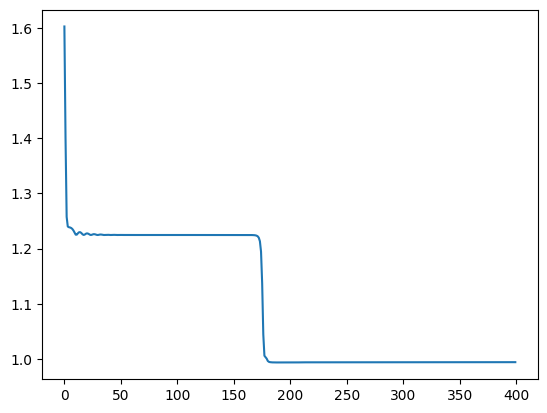

In [136]:
data_used = [0, 1, 2, 3]
train(transformer, 
    epochs=200,
    batch_size=len(data_used),
    lr=0.01,
    weight_decay=0.001,
    data=data)
data.plot_loss()
accuracy(transformer, *gen_goal())

In [79]:
accuracy(transformer, *gen_goal())
gen_goal()

tensor([1, 1, 3]) -> 2 (expected 1)
tensor([1, 2, 3]) -> 2 (expected 2)
tensor([2, 1, 3]) -> 2 (expected 2)
tensor([2, 2, 3]) -> 2 (expected 1)
Accuracy: 0.5


(tensor([[1, 1, 3],
         [1, 2, 3],
         [2, 1, 3],
         [2, 2, 3]]),
 tensor([[1],
         [2],
         [2],
         [1]]))